作业：从零开始构建三层神经网络分类器，实现图像分类

任务描述：
手工搭建三层神经网络分类器，在数据集[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)上进行训练以实现图像分类。

基本要求：
1. 本次作业要求自主实现反向传播，不允许使用pytorch，tensorflow等现成的支持自动微分的深度学习框架，可以使用numpy；
2. 最终提交的代码中应至少包含模型、训练、测试和参数查找四个部分，鼓励进行模块化设计；
3. 其中模型部分应允许自定义隐藏层大小、激活函数类型，支持通过反向传播计算给定损失的梯度；训练部分应实现SGD优化器、学习率下降、交叉熵损失和L2正则化，并能根据验证集指标自动保存最优的模型权重；参数查找环节要求调节学习率、隐藏层大小、正则化强度等超参数，观察并记录模型在不同超参数下的性能；测试部分需支持导入训练好的模型，输出在测试集上的分类准确率（Accuracy）。

提交要求：
1. 仅提交pdf格式的实验报告，报告中除对模型、数据集和实验结果的基本介绍外，还应可视化训练过程中在训练集和验证集上的loss曲线和验证集上的accuracy曲线；
2. 报告中需包含对训练好的模型网络参数的可视化，并观察其中的模式；
3. 代码提交到自己的public github repo，repo的readme中应清晰指明如何进行训练和测试，训练好的模型权重上传到百度云/google drive等网盘，实验报告内应包含实验代码所在的github repo链接及模型权重的下载地址。

注意：本次作业是个人作业，不可组队。

In [1]:
import sys
sys.path.append('/home/longkailin/nndn_hw/hw1')
sys.path.append('/home/longkailin/nndn_hw/hw1/dnn')

import os
import numpy as np
import matplotlib.pyplot as plt
from data import *
from dnn.utils import DataLoader
import dnn.neural_network_func as nn
from dnn.optim import SGD
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
import pickle

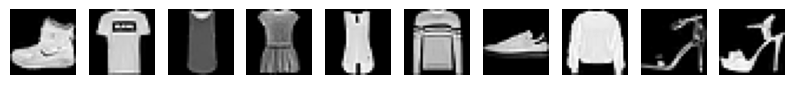

In [2]:
# Specify the directory where the Fashion-MNIST data files are located
working_dir = '/home/longkailin/nndn_hw/hw1'
data_dir = os.path.join(working_dir, 'data')

# Load training set
train_images = load_mnist_images(os.path.join(data_dir, 'train-images-idx3-ubyte.gz'))
train_labels = load_mnist_labels(os.path.join(data_dir, 'train-labels-idx1-ubyte.gz')).astype(np.int32)

# Load test set
test_images = load_mnist_images(os.path.join(data_dir, 't10k-images-idx3-ubyte.gz'))
test_labels = load_mnist_labels(os.path.join(data_dir, 't10k-labels-idx1-ubyte.gz')).astype(np.int32)

# Normalize pixel values to [0, 1]
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Visualize the first 10 images in the training set

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].imshow(train_images[i].reshape(28, 28), cmap='gray')
    ax[i].axis('off')
plt.show()


In [3]:
# Flatten images
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

# Initialize the dataloaders

## Split the training set into training and validation sets
np.random.seed(0)
indices = np.random.permutation(train_images.shape[0])
train_indices = indices[:50000]
val_indices = indices[50000:]


train_dataloader = DataLoader(train_images[train_indices], train_labels[train_indices], batch_size=32)
val_dataloader = DataLoader(train_images[val_indices], train_labels[val_indices], batch_size=32)
test_dataloader = DataLoader(test_images, test_labels, batch_size=32)

In [4]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features, hid_size = 128, activation = 'relu'):
        super(MLP, self).__init__()
        if activation == 'relu':
            self.layers = [
                nn.Linear(in_features, hid_size),
                nn.relu(),
                nn.Linear(hid_size, out_features),
                nn.SoftMax()
            ]
        
        elif activation == 'sigmoid':
            self.layers = [
                nn.Linear(in_features, hid_size),
                nn.Sigmoid(),
                nn.Linear(hid_size, out_features),
                nn.SoftMax()
            ]
        

## Training function

In [5]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, save_path='best_model.npy'):
    # best_val_loss = float('inf')
    
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    for i in tqdm(range(num_epochs)):
        total_loss = []
        total_acc = []
        for (inputs, targets) in train_loader:
            # Forward pass
            targets = targets.flatten()
            probs = model.forward(inputs)
            L = criterion(probs, targets)
            y_pred = np.argmax(probs, axis=1)
            total_loss.append(L.loss)
            total_acc.append((y_pred == targets).mean())

            # Backward pass
            L.backward()
            optimizer.step()
        # print(np.mean(total_loss))
        train_loss.append(np.mean(total_loss))
        train_acc.append(np.mean(total_acc))
        
        # Validation
        total_loss = []
        total_acc = []
        for inputs, targets in val_loader:
            # Forward pass
            targets = targets.flatten()
            probs = model.forward(inputs)
            L = criterion(probs, targets)
            y_pred = np.argmax(probs, axis=1)
            
            total_loss.append(L.loss)
            total_acc.append((y_pred == targets).mean())
        
        val_loss.append(np.mean(total_loss))
        val_acc.append(np.mean(total_acc))
        
        
        if (i+1) % 5 == 0:
            print(f'Epoch {i+1}/{num_epochs}, Train Loss: {train_loss[i]}, Val Loss: {val_loss[i]}')
        
    return train_loss, train_acc, val_loss, val_acc

In [ ]:
in_features = 784
out_features = 10
hid_size = 128
l2_lambda = 0.0
activation_func = 'relu'
num_epochs = 10

model1 = MLP(784, 10, hid_size=hid_size, activation=activation_func)
criterion = nn.CrossEntropyLoss(model1)
optimizer = SGD(model1)

train_loss, train_acc, val_loss, val_acc = train(model1, train_dataloader, val_dataloader, criterion, optimizer, num_epochs = num_epochs)

## Hyperparameters Searching: Grid Search

### Notice: it is not recommended to run this grid search because it took a long time to finish. You can skip this part and directly load the best model from the next part.

Hyperparameters such as hidden layer size, learning rate, regularization strength, etc. are crucial to the performance of the model. In this notebook, we will implement a simple **parameter grid search** to find the best hyperparameters for our model.

In [6]:
parameter_grid = {
    'hid_size': [128, 256],
    'activation_func': ['relu', 'sigmoid'],
    'lr': [0.05, 0.1, 0.5],
    'l2_lambda': [0.0, 0.05, 0.1],
    'decay_rate': [0.0, 1e-4],
}

grid = ParameterGrid(parameter_grid)
num_epochs = 50
train_loss_dict = {}
val_loss_dict = {}
train_acc_dict = {}
val_acc_dict = {}

model_dict = {}
i = 0
for params in grid:
    
    hid_size, activation_func, lr, l2_lambda, decay_rate = params['hid_size'], params['activation_func'], params['lr'], params['l2_lambda'], params['decay_rate']
    print("params: " + str(params))
    model = MLP(784, 10, hid_size=hid_size, activation=activation_func)
    criterion = nn.CrossEntropyLoss(model, l2_lambda=l2_lambda)
    optimizer = SGD(model, initial_learning_rate=lr, decay_rate=decay_rate, l2_lambda=l2_lambda)
    train_loss, train_acc, val_loss, val_acc = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs)
    train_loss_dict[f'params_{i}'] = train_loss
    val_loss_dict[f'params_{i}'] = val_loss
    train_acc_dict[f'params_{i}'] = train_acc
    val_acc_dict[f'params_{i}'] = val_acc
    
    # Save the model
    model_dict[f'params_{i}'] = model
    i += 1
    
    

params: {'activation_func': 'relu', 'decay_rate': 0.0, 'hid_size': 128, 'l2_lambda': 0.0, 'lr': 0.05}


 10%|█         | 5/50 [01:45<13:33, 18.08s/it]

Epoch 5/50, Train Loss: 2.9019982343671282, Val Loss: 2.8693814400178956


 20%|██        | 10/50 [03:34<13:39, 20.49s/it]

Epoch 10/50, Train Loss: 2.078883716612524, Val Loss: 2.2725192750670926


 30%|███       | 15/50 [04:31<07:16, 12.48s/it]

Epoch 15/50, Train Loss: 1.546323706349648, Val Loss: 1.6336123241326013


 40%|████      | 20/50 [05:34<06:01, 12.04s/it]

Epoch 20/50, Train Loss: 1.2371512892048058, Val Loss: 1.3987551783856336


 50%|█████     | 25/50 [06:57<05:44, 13.76s/it]

Epoch 25/50, Train Loss: 1.0654200230813624, Val Loss: 1.2227047635542452


 60%|██████    | 30/50 [07:43<03:18,  9.91s/it]

Epoch 30/50, Train Loss: 0.9602572779900344, Val Loss: 1.463994512133519


 70%|███████   | 35/50 [08:49<03:13, 12.90s/it]

Epoch 35/50, Train Loss: 0.8874091397096265, Val Loss: 1.0176960947797946


 80%|████████  | 40/50 [10:07<02:25, 14.56s/it]

Epoch 40/50, Train Loss: 0.832132628928328, Val Loss: 1.0598070848336014


 90%|█████████ | 45/50 [10:53<00:44,  8.90s/it]

Epoch 45/50, Train Loss: 0.79038138351028, Val Loss: 0.9335262199017325


100%|██████████| 50/50 [11:37<00:00, 13.95s/it]


Epoch 50/50, Train Loss: 0.7554690562805233, Val Loss: 0.8635038342754225
params: {'activation_func': 'relu', 'decay_rate': 0.0, 'hid_size': 128, 'l2_lambda': 0.0, 'lr': 0.1}


 10%|█         | 5/50 [01:07<09:01, 12.03s/it]

Epoch 5/50, Train Loss: 2.065289500411577, Val Loss: 2.1688369077122838


 20%|██        | 10/50 [02:53<13:18, 19.96s/it]

Epoch 10/50, Train Loss: 1.2012404957051421, Val Loss: 1.3510640087330028


 30%|███       | 15/50 [04:15<09:00, 15.44s/it]

Epoch 15/50, Train Loss: 0.9467754749987386, Val Loss: 0.9996448509003858


 40%|████      | 20/50 [05:31<08:19, 16.64s/it]

Epoch 20/50, Train Loss: 0.8207019049984382, Val Loss: 0.9311519248269182


 50%|█████     | 25/50 [06:30<05:21, 12.86s/it]

Epoch 25/50, Train Loss: 0.7420655869666912, Val Loss: 0.8604415500158843


 60%|██████    | 30/50 [08:11<06:57, 20.86s/it]

Epoch 30/50, Train Loss: 0.6885162235015895, Val Loss: 1.3757401621009635


 70%|███████   | 35/50 [09:06<03:03, 12.24s/it]

Epoch 35/50, Train Loss: 0.6516859027759275, Val Loss: 0.7340607082927637


 80%|████████  | 40/50 [10:24<02:50, 17.05s/it]

Epoch 40/50, Train Loss: 0.6244310633686069, Val Loss: 0.7132481026502893


 90%|█████████ | 45/50 [11:35<01:15, 15.12s/it]

Epoch 45/50, Train Loss: 0.6040868296003011, Val Loss: 0.7495553255011671


100%|██████████| 50/50 [13:04<00:00, 15.68s/it]


Epoch 50/50, Train Loss: 0.5875265972050163, Val Loss: 0.6549822289189057
params: {'activation_func': 'relu', 'decay_rate': 0.0, 'hid_size': 128, 'l2_lambda': 0.0, 'lr': 0.5}


 10%|█         | 5/50 [00:46<06:42,  8.95s/it]

Epoch 5/50, Train Loss: 0.8013334968623468, Val Loss: 1.086941969930145


 20%|██        | 10/50 [02:27<15:35, 23.39s/it]

Epoch 10/50, Train Loss: 0.6176140033338186, Val Loss: 0.7338424961467926


 30%|███       | 15/50 [04:16<11:25, 19.58s/it]

Epoch 15/50, Train Loss: 0.5588208977299797, Val Loss: 0.6411025420712276


 40%|████      | 20/50 [05:46<08:30, 17.01s/it]

Epoch 20/50, Train Loss: 0.5248323679394891, Val Loss: 0.6155412139813711


 50%|█████     | 25/50 [07:03<06:07, 14.71s/it]

Epoch 25/50, Train Loss: 0.5018548254791713, Val Loss: 0.6077161327536679


 60%|██████    | 30/50 [08:10<04:30, 13.54s/it]

Epoch 30/50, Train Loss: 0.48388528963231425, Val Loss: 0.5795809830389917


 70%|███████   | 35/50 [09:11<02:55, 11.71s/it]

Epoch 35/50, Train Loss: 0.4695774354102811, Val Loss: 0.5766209511454282


 80%|████████  | 40/50 [10:24<02:02, 12.28s/it]

Epoch 40/50, Train Loss: 0.4565831999517748, Val Loss: 0.5998135996977205


 90%|█████████ | 45/50 [11:11<00:48,  9.62s/it]

Epoch 45/50, Train Loss: 0.44693382980597723, Val Loss: 0.5791196923533526


100%|██████████| 50/50 [12:16<00:00, 14.74s/it]


Epoch 50/50, Train Loss: 0.43650258228760475, Val Loss: 0.5824258656893606
params: {'activation_func': 'relu', 'decay_rate': 0.0, 'hid_size': 128, 'l2_lambda': 0.05, 'lr': 0.05}


 10%|█         | 5/50 [01:22<14:13, 18.96s/it]

Epoch 5/50, Train Loss: 2.302659179470866, Val Loss: 2.302942769598233


 20%|██        | 10/50 [02:12<08:06, 12.16s/it]

Epoch 10/50, Train Loss: 2.302594861077803, Val Loss: 2.3028215632847773


 30%|███       | 15/50 [03:20<07:38, 13.10s/it]

Epoch 15/50, Train Loss: 2.302587860745544, Val Loss: 2.3027891763833903


 40%|████      | 20/50 [05:06<09:18, 18.62s/it]

Epoch 20/50, Train Loss: 2.3025885417632983, Val Loss: 2.302780515624341


 50%|█████     | 25/50 [05:46<04:17, 10.30s/it]

Epoch 25/50, Train Loss: 2.3025883109618777, Val Loss: 2.3027713444477254


 60%|██████    | 30/50 [06:35<03:04,  9.25s/it]

Epoch 30/50, Train Loss: 2.302589294463452, Val Loss: 2.302771708515442


 70%|███████   | 35/50 [07:10<01:49,  7.33s/it]

Epoch 35/50, Train Loss: 2.3025883951885735, Val Loss: 2.3027733126959653


 80%|████████  | 40/50 [08:29<02:26, 14.66s/it]

Epoch 40/50, Train Loss: 2.302588493553866, Val Loss: 2.3027724321608534


 90%|█████████ | 45/50 [09:31<01:02, 12.42s/it]

Epoch 45/50, Train Loss: 2.302586867894609, Val Loss: 2.302786358226051


100%|██████████| 50/50 [10:54<00:00, 13.08s/it]


Epoch 50/50, Train Loss: 2.3025879875960524, Val Loss: 2.3027817423371366
params: {'activation_func': 'relu', 'decay_rate': 0.0, 'hid_size': 128, 'l2_lambda': 0.05, 'lr': 0.1}


 10%|█         | 5/50 [01:20<14:12, 18.95s/it]

Epoch 5/50, Train Loss: 2.3026181844879265, Val Loss: 2.302826920736904


 20%|██        | 10/50 [02:49<11:42, 17.55s/it]

Epoch 10/50, Train Loss: 2.3026058924094714, Val Loss: 2.3027923720199213


 30%|███       | 15/50 [03:51<08:25, 14.44s/it]

Epoch 15/50, Train Loss: 2.302608817056598, Val Loss: 2.3027508020778855


 40%|████      | 20/50 [05:32<09:53, 19.80s/it]

Epoch 20/50, Train Loss: 2.302606695687333, Val Loss: 2.302785799900854


 50%|█████     | 25/50 [06:49<06:27, 15.51s/it]

Epoch 25/50, Train Loss: 2.3026082086340827, Val Loss: 2.302780012361961


 60%|██████    | 30/50 [08:13<06:05, 18.26s/it]

Epoch 30/50, Train Loss: 2.302606319186172, Val Loss: 2.30278976293352


 70%|███████   | 35/50 [09:54<05:31, 22.12s/it]

Epoch 35/50, Train Loss: 2.3026084048102033, Val Loss: 2.3027708748881386


 80%|████████  | 40/50 [10:47<01:58, 11.84s/it]

Epoch 40/50, Train Loss: 2.3026094545026825, Val Loss: 2.302762777983629


 90%|█████████ | 45/50 [11:37<00:52, 10.54s/it]

Epoch 45/50, Train Loss: 2.302609561142565, Val Loss: 2.3027448833238875


100%|██████████| 50/50 [12:13<00:00, 14.68s/it]


Epoch 50/50, Train Loss: 2.302607799839294, Val Loss: 2.302772457057098
params: {'activation_func': 'relu', 'decay_rate': 0.0, 'hid_size': 128, 'l2_lambda': 0.05, 'lr': 0.5}


 10%|█         | 5/50 [00:27<04:10,  5.56s/it]

Epoch 5/50, Train Loss: 2.3027223555418868, Val Loss: 2.3030497335148987


 20%|██        | 10/50 [01:32<08:37, 12.94s/it]

Epoch 10/50, Train Loss: 2.3027448326240876, Val Loss: 2.302646687612793


 30%|███       | 15/50 [02:20<06:00, 10.30s/it]

Epoch 15/50, Train Loss: 2.3027130161578127, Val Loss: 2.3031396479784707


 40%|████      | 20/50 [03:39<07:08, 14.30s/it]

Epoch 20/50, Train Loss: 2.302733832277289, Val Loss: 2.302787731568164


 50%|█████     | 25/50 [05:14<07:56, 19.08s/it]

Epoch 25/50, Train Loss: 2.3027160686246733, Val Loss: 2.3028915906203626


 60%|██████    | 30/50 [07:10<07:47, 23.39s/it]

Epoch 30/50, Train Loss: 2.302683662563997, Val Loss: 2.3028332430370053


 70%|███████   | 35/50 [08:42<04:29, 17.98s/it]

Epoch 35/50, Train Loss: 2.3027478083841886, Val Loss: 2.302705433319277


 80%|████████  | 40/50 [10:16<02:48, 16.87s/it]

Epoch 40/50, Train Loss: 2.3026992808639934, Val Loss: 2.3028499948786494


 90%|█████████ | 45/50 [11:21<01:10, 14.16s/it]

Epoch 45/50, Train Loss: 2.30274569657441, Val Loss: 2.3027982915066754


100%|██████████| 50/50 [12:39<00:00, 15.19s/it]


Epoch 50/50, Train Loss: 2.3027436723464696, Val Loss: 2.302775725641014
params: {'activation_func': 'relu', 'decay_rate': 0.0, 'hid_size': 128, 'l2_lambda': 0.1, 'lr': 0.05}


 10%|█         | 5/50 [00:56<08:06, 10.81s/it]

Epoch 5/50, Train Loss: 2.302614902067769, Val Loss: 2.3027721240306627


 20%|██        | 10/50 [01:49<06:27,  9.69s/it]

Epoch 10/50, Train Loss: 2.3025899081688244, Val Loss: 2.302772591170562


 30%|███       | 15/50 [02:23<04:01,  6.89s/it]

Epoch 15/50, Train Loss: 2.302589159750017, Val Loss: 2.3027699448806542


 40%|████      | 20/50 [02:57<03:32,  7.07s/it]

Epoch 20/50, Train Loss: 2.302588220667486, Val Loss: 2.302774272126271


 50%|█████     | 25/50 [03:38<03:24,  8.18s/it]

Epoch 25/50, Train Loss: 2.30258836060818, Val Loss: 2.302776193967727


 60%|██████    | 30/50 [04:20<02:38,  7.94s/it]

Epoch 30/50, Train Loss: 2.3025866529775914, Val Loss: 2.3027748199155336


 70%|███████   | 35/50 [04:55<02:01,  8.07s/it]

Epoch 35/50, Train Loss: 2.302587512892661, Val Loss: 2.3027728418468185


 80%|████████  | 40/50 [05:52<01:43, 10.32s/it]

Epoch 40/50, Train Loss: 2.302588172276071, Val Loss: 2.302773862972566


 90%|█████████ | 45/50 [06:41<00:49,  9.87s/it]

Epoch 45/50, Train Loss: 2.3025890888224425, Val Loss: 2.302763428178402


100%|██████████| 50/50 [08:12<00:00,  9.86s/it]


Epoch 50/50, Train Loss: 2.3025884432210195, Val Loss: 2.3027665898714087
params: {'activation_func': 'relu', 'decay_rate': 0.0, 'hid_size': 128, 'l2_lambda': 0.1, 'lr': 0.1}


 10%|█         | 5/50 [00:43<05:55,  7.90s/it]

Epoch 5/50, Train Loss: 2.3026109741244576, Val Loss: 2.3027557452994287


 20%|██        | 10/50 [01:42<07:21, 11.04s/it]

Epoch 10/50, Train Loss: 2.3026083111188753, Val Loss: 2.3027868038688992


 30%|███       | 15/50 [02:08<03:33,  6.10s/it]

Epoch 15/50, Train Loss: 2.3026079492824434, Val Loss: 2.3027602867729717


 40%|████      | 20/50 [02:57<04:33,  9.13s/it]

Epoch 20/50, Train Loss: 2.302609818404406, Val Loss: 2.302783543436036


 50%|█████     | 25/50 [03:48<04:15, 10.20s/it]

Epoch 25/50, Train Loss: 2.3026088902531257, Val Loss: 2.3027636887464022


 60%|██████    | 30/50 [04:38<03:15,  9.75s/it]

Epoch 30/50, Train Loss: 2.302608703765535, Val Loss: 2.3027723354042067


 70%|███████   | 35/50 [05:51<03:05, 12.34s/it]

Epoch 35/50, Train Loss: 2.3026079286514767, Val Loss: 2.302760592187006


 80%|████████  | 40/50 [06:35<01:33,  9.33s/it]

Epoch 40/50, Train Loss: 2.3026069570353718, Val Loss: 2.3027728737212287


 90%|█████████ | 45/50 [07:53<01:10, 14.12s/it]

Epoch 45/50, Train Loss: 2.3026098767440963, Val Loss: 2.3027697850163413


100%|██████████| 50/50 [10:09<00:00, 12.19s/it]


Epoch 50/50, Train Loss: 2.302608814029114, Val Loss: 2.3027767063648557
params: {'activation_func': 'relu', 'decay_rate': 0.0, 'hid_size': 128, 'l2_lambda': 0.1, 'lr': 0.5}


 10%|█         | 5/50 [01:12<11:24, 15.22s/it]

Epoch 5/50, Train Loss: 2.302748287480948, Val Loss: 2.3026483441023533


 20%|██        | 10/50 [02:16<08:56, 13.40s/it]

Epoch 10/50, Train Loss: 2.3027105970743587, Val Loss: 2.302929875882473


 30%|███       | 15/50 [04:20<13:37, 23.36s/it]

Epoch 15/50, Train Loss: 2.3027314217344843, Val Loss: 2.3029214225218397


 40%|████      | 20/50 [06:19<12:29, 24.99s/it]

Epoch 20/50, Train Loss: 2.3027482478483883, Val Loss: 2.302871638187367


 50%|█████     | 25/50 [08:28<10:52, 26.10s/it]

Epoch 25/50, Train Loss: 2.3026985035929406, Val Loss: 2.302897213539525


 60%|██████    | 30/50 [10:31<07:44, 23.23s/it]

Epoch 30/50, Train Loss: 2.3027378064212716, Val Loss: 2.302732192782666


 70%|███████   | 35/50 [12:34<06:09, 24.63s/it]

Epoch 35/50, Train Loss: 2.302743173733505, Val Loss: 2.3028190008220992


 80%|████████  | 40/50 [14:24<03:46, 22.69s/it]

Epoch 40/50, Train Loss: 2.302711042286443, Val Loss: 2.3027717385666904


 90%|█████████ | 45/50 [16:22<01:57, 23.57s/it]

Epoch 45/50, Train Loss: 2.3027223177944594, Val Loss: 2.302984263931363


100%|██████████| 50/50 [18:03<00:00, 21.67s/it]


Epoch 50/50, Train Loss: 2.302722708640418, Val Loss: 2.302859425845697
params: {'activation_func': 'relu', 'decay_rate': 0.0, 'hid_size': 256, 'l2_lambda': 0.0, 'lr': 0.05}


 10%|█         | 5/50 [00:59<08:45, 11.68s/it]

Epoch 5/50, Train Loss: 3.1323301097334895, Val Loss: 3.221528428144063


 20%|██        | 10/50 [01:48<06:49, 10.23s/it]

Epoch 10/50, Train Loss: 2.541507480746884, Val Loss: 2.7794264437549336


 30%|███       | 15/50 [02:41<06:24, 10.99s/it]

Epoch 15/50, Train Loss: 2.1906152378163366, Val Loss: 2.3999472338114316


 40%|████      | 20/50 [03:30<04:59, 10.00s/it]

Epoch 20/50, Train Loss: 1.936351920473639, Val Loss: 2.300809169440396


 50%|█████     | 25/50 [04:26<04:32, 10.88s/it]

Epoch 25/50, Train Loss: 1.744204857331461, Val Loss: 2.0336501745158757


 60%|██████    | 30/50 [05:22<03:43, 11.19s/it]

Epoch 30/50, Train Loss: 1.5632240745972652, Val Loss: 1.8231797496188678


 70%|███████   | 35/50 [06:23<02:53, 11.58s/it]

Epoch 35/50, Train Loss: 1.4089973514476417, Val Loss: 1.7992280983900706


 80%|████████  | 40/50 [07:11<01:38,  9.90s/it]

Epoch 40/50, Train Loss: 1.2740295620389586, Val Loss: 1.6313436660989986


 90%|█████████ | 45/50 [08:01<00:50, 10.10s/it]

Epoch 45/50, Train Loss: 1.1567380564808352, Val Loss: 1.414254416618308


100%|██████████| 50/50 [08:57<00:00, 10.75s/it]


Epoch 50/50, Train Loss: 1.0600460190779004, Val Loss: 1.3832589537019728
params: {'activation_func': 'relu', 'decay_rate': 0.0, 'hid_size': 256, 'l2_lambda': 0.0, 'lr': 0.1}


 10%|█         | 5/50 [00:57<08:52, 11.83s/it]

Epoch 5/50, Train Loss: 2.5418770036770115, Val Loss: 2.929456762507127


 20%|██        | 10/50 [01:55<07:43, 11.59s/it]

Epoch 10/50, Train Loss: 1.9831488105219994, Val Loss: 2.4985368590503105


 30%|███       | 15/50 [02:45<05:52, 10.08s/it]

Epoch 15/50, Train Loss: 1.6007577205114878, Val Loss: 1.9178516188564867


 40%|████      | 20/50 [03:39<05:35, 11.20s/it]

Epoch 20/50, Train Loss: 1.3371086397675644, Val Loss: 1.6117158156985814


 50%|█████     | 25/50 [04:37<04:56, 11.88s/it]

Epoch 25/50, Train Loss: 1.1411075687975978, Val Loss: 1.9720311341487957


 60%|██████    | 30/50 [05:23<03:24, 10.25s/it]

Epoch 30/50, Train Loss: 1.0028972852307845, Val Loss: 1.2406094542921386


 70%|███████   | 35/50 [06:07<02:09,  8.66s/it]

Epoch 35/50, Train Loss: 0.9068053533445822, Val Loss: 1.350242954406172


 80%|████████  | 40/50 [07:04<01:54, 11.49s/it]

Epoch 40/50, Train Loss: 0.8274918977407352, Val Loss: 1.1081271778791666


 90%|█████████ | 45/50 [08:11<01:03, 12.79s/it]

Epoch 45/50, Train Loss: 0.7733383173812515, Val Loss: 1.8138783238530614


100%|██████████| 50/50 [09:05<00:00, 10.91s/it]


Epoch 50/50, Train Loss: 0.7208061519934819, Val Loss: 1.0745616599449122
params: {'activation_func': 'relu', 'decay_rate': 0.0, 'hid_size': 256, 'l2_lambda': 0.0, 'lr': 0.5}


 10%|█         | 5/50 [00:48<07:30, 10.01s/it]

Epoch 5/50, Train Loss: 1.0454926265607178, Val Loss: 1.2070993521965614


 20%|██        | 10/50 [01:39<07:07, 10.69s/it]

Epoch 10/50, Train Loss: 0.690565560982314, Val Loss: 0.9192364188573684


 30%|███       | 15/50 [02:26<05:46,  9.89s/it]

Epoch 15/50, Train Loss: 0.5792847836380243, Val Loss: 0.8058425998981275


 40%|████      | 20/50 [03:20<05:29, 11.00s/it]

Epoch 20/50, Train Loss: 0.5172222975423882, Val Loss: 0.8234847548562888


 50%|█████     | 25/50 [04:15<04:33, 10.92s/it]

Epoch 25/50, Train Loss: 0.4775059035197642, Val Loss: 0.709926313236183


 60%|██████    | 30/50 [04:57<02:53,  8.69s/it]

Epoch 30/50, Train Loss: 0.44965245682085137, Val Loss: 0.6673122016374243


 70%|███████   | 35/50 [05:52<02:39, 10.62s/it]

Epoch 35/50, Train Loss: 0.4274917857559945, Val Loss: 0.6697681722966561


 80%|████████  | 40/50 [06:51<01:55, 11.53s/it]

Epoch 40/50, Train Loss: 0.40996219424243324, Val Loss: 0.6594950185326218


 90%|█████████ | 45/50 [07:48<00:56, 11.20s/it]

Epoch 45/50, Train Loss: 0.3945205158196762, Val Loss: 0.6421890306210142


100%|██████████| 50/50 [08:31<00:00, 10.23s/it]


Epoch 50/50, Train Loss: 0.382339484574328, Val Loss: 0.6593198737905415
params: {'activation_func': 'relu', 'decay_rate': 0.0, 'hid_size': 256, 'l2_lambda': 0.05, 'lr': 0.05}


 10%|█         | 5/50 [00:46<06:48,  9.07s/it]

Epoch 5/50, Train Loss: 2.3026830437236456, Val Loss: 2.3028164265540565


 20%|██        | 10/50 [01:34<06:27,  9.70s/it]

Epoch 10/50, Train Loss: 2.3025999401563966, Val Loss: 2.3027685880980524


 30%|███       | 15/50 [02:36<07:09, 12.27s/it]

Epoch 15/50, Train Loss: 2.302590159900451, Val Loss: 2.3027625471265627


 40%|████      | 20/50 [03:37<05:58, 11.96s/it]

Epoch 20/50, Train Loss: 2.3025889600418092, Val Loss: 2.302770867084903


 50%|█████     | 25/50 [04:28<04:17, 10.28s/it]

Epoch 25/50, Train Loss: 2.3025888793665397, Val Loss: 2.3027711736263723


 60%|██████    | 30/50 [05:18<03:14,  9.71s/it]

Epoch 30/50, Train Loss: 2.3025884641495176, Val Loss: 2.302773215025741


 70%|███████   | 35/50 [06:14<02:47, 11.20s/it]

Epoch 35/50, Train Loss: 2.302587938664463, Val Loss: 2.3027712929304283


 80%|████████  | 40/50 [07:07<01:44, 10.41s/it]

Epoch 40/50, Train Loss: 2.3025889511971753, Val Loss: 2.3027722809153373


 90%|█████████ | 45/50 [08:00<00:52, 10.55s/it]

Epoch 45/50, Train Loss: 2.3025887356756694, Val Loss: 2.3027773357020873


100%|██████████| 50/50 [08:52<00:00, 10.66s/it]


Epoch 50/50, Train Loss: 2.302589950203202, Val Loss: 2.3027818446040516
params: {'activation_func': 'relu', 'decay_rate': 0.0, 'hid_size': 256, 'l2_lambda': 0.05, 'lr': 0.1}


 10%|█         | 5/50 [00:54<08:00, 10.68s/it]

Epoch 5/50, Train Loss: 2.3026169151498475, Val Loss: 2.302770310998618


 20%|██        | 10/50 [01:47<07:04, 10.61s/it]

Epoch 10/50, Train Loss: 2.3026082581832776, Val Loss: 2.3027836061374436


 30%|███       | 15/50 [02:38<06:04, 10.42s/it]

Epoch 15/50, Train Loss: 2.3026071606354024, Val Loss: 2.302752916479147


 40%|████      | 20/50 [03:25<04:28,  8.96s/it]

Epoch 20/50, Train Loss: 2.3026053854989215, Val Loss: 2.3027795226370156


 50%|█████     | 25/50 [04:15<04:12, 10.10s/it]

Epoch 25/50, Train Loss: 2.3026090963090624, Val Loss: 2.3027997348215377


 60%|██████    | 30/50 [04:59<02:53,  8.69s/it]

Epoch 30/50, Train Loss: 2.302605985474598, Val Loss: 2.3027671881058582


 70%|███████   | 35/50 [05:42<02:10,  8.71s/it]

Epoch 35/50, Train Loss: 2.3026104000854506, Val Loss: 2.302728350030853


 80%|████████  | 40/50 [06:35<01:48, 10.81s/it]

Epoch 40/50, Train Loss: 2.3026102489885325, Val Loss: 2.3027550480309564


 90%|█████████ | 45/50 [07:31<00:55, 11.08s/it]

Epoch 45/50, Train Loss: 2.302607438169798, Val Loss: 2.302782905896394


100%|██████████| 50/50 [08:54<00:00, 10.68s/it]


Epoch 50/50, Train Loss: 2.3026081783549253, Val Loss: 2.302800212032842
params: {'activation_func': 'relu', 'decay_rate': 0.0, 'hid_size': 256, 'l2_lambda': 0.05, 'lr': 0.5}


 10%|█         | 5/50 [00:49<07:25,  9.89s/it]

Epoch 5/50, Train Loss: 2.302740777918612, Val Loss: 2.3028636641008484


 20%|██        | 10/50 [01:47<08:01, 12.04s/it]

Epoch 10/50, Train Loss: 2.3027072169448117, Val Loss: 2.3031760523171507


 30%|███       | 15/50 [02:35<05:51, 10.03s/it]

Epoch 15/50, Train Loss: 2.3027283117704163, Val Loss: 2.302838881335627


 40%|████      | 20/50 [03:54<08:33, 17.13s/it]

Epoch 20/50, Train Loss: 2.3027427734069956, Val Loss: 2.302775134230804


 50%|█████     | 25/50 [05:20<06:20, 15.21s/it]

Epoch 25/50, Train Loss: 2.302741013763929, Val Loss: 2.3028040495410886


 60%|██████    | 30/50 [06:14<03:50, 11.51s/it]

Epoch 30/50, Train Loss: 2.302757940342407, Val Loss: 2.3028885697160413


 70%|███████   | 35/50 [07:07<02:42, 10.80s/it]

Epoch 35/50, Train Loss: 2.3027007006033977, Val Loss: 2.302646796328557


 80%|████████  | 40/50 [08:01<01:46, 10.68s/it]

Epoch 40/50, Train Loss: 2.302754683559594, Val Loss: 2.302844743590061


 90%|█████████ | 45/50 [08:54<00:53, 10.69s/it]

Epoch 45/50, Train Loss: 2.30273559686561, Val Loss: 2.3026181239236685


100%|██████████| 50/50 [09:48<00:00, 11.76s/it]


Epoch 50/50, Train Loss: 2.3027615215446646, Val Loss: 2.302702766884768
params: {'activation_func': 'relu', 'decay_rate': 0.0, 'hid_size': 256, 'l2_lambda': 0.1, 'lr': 0.05}


 10%|█         | 5/50 [00:28<04:16,  5.70s/it]

Epoch 5/50, Train Loss: 2.302602462796746, Val Loss: 2.3027567438910066


 20%|██        | 10/50 [00:57<03:50,  5.77s/it]

Epoch 10/50, Train Loss: 2.3025898906494513, Val Loss: 2.302764062805089


 30%|███       | 15/50 [01:26<03:20,  5.72s/it]

Epoch 15/50, Train Loss: 2.302587971335783, Val Loss: 2.302773886221148


 40%|████      | 20/50 [01:54<02:50,  5.69s/it]

Epoch 20/50, Train Loss: 2.3025881124482845, Val Loss: 2.3027737274868265


 50%|█████     | 25/50 [02:23<02:22,  5.70s/it]

Epoch 25/50, Train Loss: 2.302587936584969, Val Loss: 2.3027771733977778


 60%|██████    | 30/50 [02:51<01:54,  5.70s/it]

Epoch 30/50, Train Loss: 2.302586632364548, Val Loss: 2.302788683155821


 70%|███████   | 35/50 [03:19<01:23,  5.58s/it]

Epoch 35/50, Train Loss: 2.3025870007923657, Val Loss: 2.3027813819021734


 80%|████████  | 40/50 [03:48<00:57,  5.70s/it]

Epoch 40/50, Train Loss: 2.3025876787844113, Val Loss: 2.3027818719203106


 90%|█████████ | 45/50 [04:17<00:29,  5.88s/it]

Epoch 45/50, Train Loss: 2.3025879058681444, Val Loss: 2.3027803075002


100%|██████████| 50/50 [04:59<00:00,  6.00s/it]


Epoch 50/50, Train Loss: 2.3025890375696, Val Loss: 2.3027719846187273
params: {'activation_func': 'relu', 'decay_rate': 0.0, 'hid_size': 256, 'l2_lambda': 0.1, 'lr': 0.1}


 10%|█         | 5/50 [00:27<04:05,  5.46s/it]

Epoch 5/50, Train Loss: 2.30260887578488, Val Loss: 2.302806891860379


 20%|██        | 10/50 [00:54<03:36,  5.42s/it]

Epoch 10/50, Train Loss: 2.3026079858162394, Val Loss: 2.302803179753904


 30%|███       | 15/50 [01:22<03:17,  5.64s/it]

Epoch 15/50, Train Loss: 2.3026111110579284, Val Loss: 2.302761894098348


 40%|████      | 20/50 [01:50<02:48,  5.60s/it]

Epoch 20/50, Train Loss: 2.302608193067223, Val Loss: 2.3027584780562953


 50%|█████     | 25/50 [02:25<02:51,  6.87s/it]

Epoch 25/50, Train Loss: 2.302610085095473, Val Loss: 2.3027515574841932


 60%|██████    | 30/50 [02:52<01:54,  5.73s/it]

Epoch 30/50, Train Loss: 2.3026084536706115, Val Loss: 2.3027732729457835


 70%|███████   | 35/50 [03:20<01:23,  5.54s/it]

Epoch 35/50, Train Loss: 2.3026089161610646, Val Loss: 2.3027843619035178


 80%|████████  | 40/50 [03:48<00:55,  5.51s/it]

Epoch 40/50, Train Loss: 2.302606921079512, Val Loss: 2.302801888289586


 90%|█████████ | 45/50 [04:16<00:29,  5.86s/it]

Epoch 45/50, Train Loss: 2.3026085358435884, Val Loss: 2.3027591268721856


100%|██████████| 50/50 [05:09<00:00,  6.19s/it]


Epoch 50/50, Train Loss: 2.3026059157506555, Val Loss: 2.302788109231699
params: {'activation_func': 'relu', 'decay_rate': 0.0, 'hid_size': 256, 'l2_lambda': 0.1, 'lr': 0.5}


 10%|█         | 5/50 [00:28<04:24,  5.88s/it]

Epoch 5/50, Train Loss: 2.302734789435063, Val Loss: 2.3028884995954213


 20%|██        | 10/50 [01:02<04:59,  7.48s/it]

Epoch 10/50, Train Loss: 2.3027110722315385, Val Loss: 2.3028273017125604


 30%|███       | 15/50 [01:56<05:59, 10.27s/it]

Epoch 15/50, Train Loss: 2.302732482258137, Val Loss: 2.3028809426015635


 40%|████      | 20/50 [02:50<05:21, 10.72s/it]

Epoch 20/50, Train Loss: 2.3027419905716955, Val Loss: 2.302953886733496


 50%|█████     | 25/50 [03:44<04:31, 10.84s/it]

Epoch 25/50, Train Loss: 2.3027485818458078, Val Loss: 2.302829870547138


 60%|██████    | 30/50 [04:39<03:37, 10.88s/it]

Epoch 30/50, Train Loss: 2.30271648133319, Val Loss: 2.3026223787116167


 70%|███████   | 35/50 [05:34<02:45, 11.01s/it]

Epoch 35/50, Train Loss: 2.302709505224812, Val Loss: 2.302820096689083


 80%|████████  | 40/50 [06:29<01:49, 10.95s/it]

Epoch 40/50, Train Loss: 2.3027503968147656, Val Loss: 2.3027512188026327


 90%|█████████ | 45/50 [07:23<00:54, 10.84s/it]

Epoch 45/50, Train Loss: 2.3027413199169557, Val Loss: 2.302881727744139


100%|██████████| 50/50 [08:17<00:00,  9.95s/it]


Epoch 50/50, Train Loss: 2.3027310683861217, Val Loss: 2.3029162985345994
params: {'activation_func': 'relu', 'decay_rate': 0.0001, 'hid_size': 128, 'l2_lambda': 0.0, 'lr': 0.05}


 10%|█         | 5/50 [00:18<02:49,  3.76s/it]

Epoch 5/50, Train Loss: 2.859711236529131, Val Loss: 2.849426791348972


 20%|██        | 10/50 [00:37<02:30,  3.76s/it]

Epoch 10/50, Train Loss: 2.072168158717578, Val Loss: 2.1816517190931433


 30%|███       | 15/50 [00:56<02:11,  3.74s/it]

Epoch 15/50, Train Loss: 1.5754642587910732, Val Loss: 1.7465166285905376


 40%|████      | 20/50 [01:15<01:52,  3.74s/it]

Epoch 20/50, Train Loss: 1.2561778151730412, Val Loss: 1.370101686174043


 50%|█████     | 25/50 [01:33<01:33,  3.74s/it]

Epoch 25/50, Train Loss: 1.0735095200844116, Val Loss: 1.20481040653089


 60%|██████    | 30/50 [01:52<01:14,  3.74s/it]

Epoch 30/50, Train Loss: 0.9618074172369084, Val Loss: 1.1648315345441858


 70%|███████   | 35/50 [02:10<00:55,  3.67s/it]

Epoch 35/50, Train Loss: 0.886974126299937, Val Loss: 1.0696689458172457


 80%|████████  | 40/50 [02:29<00:36,  3.64s/it]

Epoch 40/50, Train Loss: 0.8301372886598413, Val Loss: 1.075406639406598


 90%|█████████ | 45/50 [02:46<00:17,  3.57s/it]

Epoch 45/50, Train Loss: 0.7871874788522583, Val Loss: 1.0362736962681265


100%|██████████| 50/50 [03:04<00:00,  3.69s/it]


Epoch 50/50, Train Loss: 0.75165736428609, Val Loss: 0.8630854063931905
params: {'activation_func': 'relu', 'decay_rate': 0.0001, 'hid_size': 128, 'l2_lambda': 0.0, 'lr': 0.1}


 10%|█         | 5/50 [00:17<02:36,  3.47s/it]

Epoch 5/50, Train Loss: 2.0342122796634414, Val Loss: 2.3886680315139217


 20%|██        | 10/50 [00:34<02:18,  3.46s/it]

Epoch 10/50, Train Loss: 1.2304553510642886, Val Loss: 1.733802350274816


 30%|███       | 15/50 [00:51<02:00,  3.45s/it]

Epoch 15/50, Train Loss: 0.9570601904887723, Val Loss: 1.092818769463998


 40%|████      | 20/50 [01:08<01:41,  3.40s/it]

Epoch 20/50, Train Loss: 0.8239986430623206, Val Loss: 1.1028527369940415


 50%|█████     | 25/50 [01:25<01:24,  3.39s/it]

Epoch 25/50, Train Loss: 0.7445999155996386, Val Loss: 0.9211578705230601


 60%|██████    | 30/50 [01:42<01:07,  3.38s/it]

Epoch 30/50, Train Loss: 0.6896937764438222, Val Loss: 0.8398857379840678


 70%|███████   | 35/50 [01:59<00:50,  3.38s/it]

Epoch 35/50, Train Loss: 0.6519329185109198, Val Loss: 0.8253152817455096


 80%|████████  | 40/50 [02:16<00:33,  3.38s/it]

Epoch 40/50, Train Loss: 0.6219716877913539, Val Loss: 0.7961999808019375


 90%|█████████ | 45/50 [02:33<00:16,  3.38s/it]

Epoch 45/50, Train Loss: 0.5982660667288228, Val Loss: 0.7081132366915913


100%|██████████| 50/50 [02:50<00:00,  3.40s/it]


Epoch 50/50, Train Loss: 0.5801057293198149, Val Loss: 0.6665966934943157
params: {'activation_func': 'relu', 'decay_rate': 0.0001, 'hid_size': 128, 'l2_lambda': 0.0, 'lr': 0.5}


 10%|█         | 5/50 [00:16<02:32,  3.39s/it]

Epoch 5/50, Train Loss: 0.7980477072808987, Val Loss: 0.9176258417788878


 20%|██        | 10/50 [00:33<02:14,  3.37s/it]

Epoch 10/50, Train Loss: 0.6124228062435785, Val Loss: 0.7188772590542142


 30%|███       | 15/50 [00:50<01:58,  3.37s/it]

Epoch 15/50, Train Loss: 0.5532102801329079, Val Loss: 0.7335547061102239


 40%|████      | 20/50 [01:07<01:40,  3.36s/it]

Epoch 20/50, Train Loss: 0.5210973497674605, Val Loss: 0.6744996814653132


 50%|█████     | 25/50 [01:24<01:24,  3.38s/it]

Epoch 25/50, Train Loss: 0.4981321740353686, Val Loss: 0.6613857320923915


 60%|██████    | 30/50 [01:41<01:07,  3.37s/it]

Epoch 30/50, Train Loss: 0.4802248541755649, Val Loss: 0.6071009150183266


 70%|███████   | 35/50 [01:58<00:50,  3.37s/it]

Epoch 35/50, Train Loss: 0.46675258652290635, Val Loss: 0.6104269445559786


 80%|████████  | 40/50 [02:14<00:33,  3.36s/it]

Epoch 40/50, Train Loss: 0.45569483398010524, Val Loss: 0.5605417440983621


 90%|█████████ | 45/50 [02:31<00:16,  3.37s/it]

Epoch 45/50, Train Loss: 0.4448161128932136, Val Loss: 0.5348364556246302


100%|██████████| 50/50 [02:48<00:00,  3.37s/it]


Epoch 50/50, Train Loss: 0.43541614176152255, Val Loss: 0.5698628147079076
params: {'activation_func': 'relu', 'decay_rate': 0.0001, 'hid_size': 128, 'l2_lambda': 0.05, 'lr': 0.05}


 10%|█         | 5/50 [00:18<02:43,  3.64s/it]

Epoch 5/50, Train Loss: 2.302669318342546, Val Loss: 2.3028471538898803


 20%|██        | 10/50 [00:36<02:23,  3.58s/it]

Epoch 10/50, Train Loss: 2.302598253109353, Val Loss: 2.302782040728916


 30%|███       | 15/50 [00:53<02:04,  3.54s/it]

Epoch 15/50, Train Loss: 2.3025880755995423, Val Loss: 2.3027760386956038


 40%|████      | 20/50 [01:11<01:43,  3.45s/it]

Epoch 20/50, Train Loss: 2.302588344806587, Val Loss: 2.3027704433110507


 50%|█████     | 25/50 [01:28<01:25,  3.43s/it]

Epoch 25/50, Train Loss: 2.3025883049225766, Val Loss: 2.3027729223290216


 60%|██████    | 30/50 [01:45<01:08,  3.43s/it]

Epoch 30/50, Train Loss: 2.3025893202935324, Val Loss: 2.3027758078732763


 70%|███████   | 35/50 [02:02<00:51,  3.43s/it]

Epoch 35/50, Train Loss: 2.3025902627188715, Val Loss: 2.30277198743312


 80%|████████  | 40/50 [02:19<00:34,  3.43s/it]

Epoch 40/50, Train Loss: 2.3025888735444116, Val Loss: 2.3027757952286128


 90%|█████████ | 45/50 [02:36<00:17,  3.42s/it]

Epoch 45/50, Train Loss: 2.302587811337123, Val Loss: 2.3027648542337475


100%|██████████| 50/50 [02:53<00:00,  3.48s/it]


Epoch 50/50, Train Loss: 2.3025881892173037, Val Loss: 2.3027830554065045
params: {'activation_func': 'relu', 'decay_rate': 0.0001, 'hid_size': 128, 'l2_lambda': 0.05, 'lr': 0.1}


 10%|█         | 5/50 [00:16<02:31,  3.36s/it]

Epoch 5/50, Train Loss: 2.302622373986402, Val Loss: 2.3027950138649107


 20%|██        | 10/50 [00:33<02:14,  3.36s/it]

Epoch 10/50, Train Loss: 2.3026078291962944, Val Loss: 2.3027725149185665


 30%|███       | 15/50 [00:50<01:56,  3.34s/it]

Epoch 15/50, Train Loss: 2.3026067857441013, Val Loss: 2.302800285237733


 40%|████      | 20/50 [01:07<01:40,  3.34s/it]

Epoch 20/50, Train Loss: 2.3026086398504493, Val Loss: 2.3027802345389605


 50%|█████     | 25/50 [01:23<01:23,  3.35s/it]

Epoch 25/50, Train Loss: 2.3026079740468233, Val Loss: 2.3027777277257133


 60%|██████    | 30/50 [01:40<01:06,  3.34s/it]

Epoch 30/50, Train Loss: 2.3026086097898277, Val Loss: 2.302774623303917


 70%|███████   | 35/50 [01:57<00:49,  3.33s/it]

Epoch 35/50, Train Loss: 2.3026089536161076, Val Loss: 2.3027525802900883


 80%|████████  | 40/50 [02:14<00:34,  3.47s/it]

Epoch 40/50, Train Loss: 2.3026081299362686, Val Loss: 2.3027704617980533


 90%|█████████ | 45/50 [02:32<00:17,  3.56s/it]

Epoch 45/50, Train Loss: 2.302606276864649, Val Loss: 2.3027639363150483


100%|██████████| 50/50 [02:58<00:00,  3.56s/it]


Epoch 50/50, Train Loss: 2.302607219805847, Val Loss: 2.3027715734500345
params: {'activation_func': 'relu', 'decay_rate': 0.0001, 'hid_size': 128, 'l2_lambda': 0.05, 'lr': 0.5}


 10%|█         | 5/50 [00:18<02:45,  3.68s/it]

Epoch 5/50, Train Loss: 2.302720922800602, Val Loss: 2.3026355166468133


 20%|██        | 10/50 [00:38<02:45,  4.14s/it]

Epoch 10/50, Train Loss: 2.3027428638210337, Val Loss: 2.302882661278678


 30%|███       | 15/50 [00:57<02:12,  3.78s/it]

Epoch 15/50, Train Loss: 2.302739326147573, Val Loss: 2.302711031996035


 40%|████      | 20/50 [01:21<02:36,  5.21s/it]

Epoch 20/50, Train Loss: 2.3027098017785774, Val Loss: 2.302745427173838


 50%|█████     | 25/50 [01:53<02:35,  6.22s/it]

Epoch 25/50, Train Loss: 2.302731292774906, Val Loss: 2.3028003470455447


 60%|██████    | 30/50 [02:25<02:06,  6.31s/it]

Epoch 30/50, Train Loss: 2.302737867556953, Val Loss: 2.3028352816890543


 70%|███████   | 35/50 [02:57<01:34,  6.29s/it]

Epoch 35/50, Train Loss: 2.3027367305998983, Val Loss: 2.3027420390903353


 80%|████████  | 40/50 [03:28<01:02,  6.29s/it]

Epoch 40/50, Train Loss: 2.3027337365320206, Val Loss: 2.302733335627538


 90%|█████████ | 45/50 [03:59<00:31,  6.29s/it]

Epoch 45/50, Train Loss: 2.3027219408433965, Val Loss: 2.302624664997483


100%|██████████| 50/50 [04:31<00:00,  5.42s/it]


Epoch 50/50, Train Loss: 2.302762290841278, Val Loss: 2.302691724664827
params: {'activation_func': 'relu', 'decay_rate': 0.0001, 'hid_size': 128, 'l2_lambda': 0.1, 'lr': 0.05}


 10%|█         | 5/50 [00:17<02:32,  3.39s/it]

Epoch 5/50, Train Loss: 2.3026052309881044, Val Loss: 2.302699610688077


 20%|██        | 10/50 [00:33<02:15,  3.38s/it]

Epoch 10/50, Train Loss: 2.302588596940888, Val Loss: 2.302757020036519


 30%|███       | 15/50 [00:50<01:58,  3.39s/it]

Epoch 15/50, Train Loss: 2.302588827343571, Val Loss: 2.302767164225594


 40%|████      | 20/50 [01:07<01:40,  3.34s/it]

Epoch 20/50, Train Loss: 2.302587848993715, Val Loss: 2.3027775073789636


 50%|█████     | 25/50 [01:24<01:23,  3.33s/it]

Epoch 25/50, Train Loss: 2.302588495756008, Val Loss: 2.302780939112737


 60%|██████    | 30/50 [01:40<01:06,  3.33s/it]

Epoch 30/50, Train Loss: 2.302587357259265, Val Loss: 2.3027780196950887


 70%|███████   | 35/50 [01:57<00:49,  3.30s/it]

Epoch 35/50, Train Loss: 2.30258890443005, Val Loss: 2.3027707272041593


 80%|████████  | 40/50 [02:13<00:32,  3.29s/it]

Epoch 40/50, Train Loss: 2.3025878281094676, Val Loss: 2.302780570929445


 90%|█████████ | 45/50 [02:30<00:16,  3.34s/it]

Epoch 45/50, Train Loss: 2.302587576645294, Val Loss: 2.302779374693258


100%|██████████| 50/50 [02:53<00:00,  3.47s/it]


Epoch 50/50, Train Loss: 2.302588069079745, Val Loss: 2.302771172028298
params: {'activation_func': 'relu', 'decay_rate': 0.0001, 'hid_size': 128, 'l2_lambda': 0.1, 'lr': 0.1}


 10%|█         | 5/50 [00:18<02:44,  3.65s/it]

Epoch 5/50, Train Loss: 2.3026075717633163, Val Loss: 2.302766661161654


 20%|██        | 10/50 [00:36<02:24,  3.62s/it]

Epoch 10/50, Train Loss: 2.3026078615010017, Val Loss: 2.3027754833778746


 30%|███       | 15/50 [00:54<02:06,  3.62s/it]

Epoch 15/50, Train Loss: 2.302608123920212, Val Loss: 2.3027638924964093


 40%|████      | 20/50 [01:12<01:49,  3.66s/it]

Epoch 20/50, Train Loss: 2.3026073390998625, Val Loss: 2.30276867634


 50%|█████     | 25/50 [01:34<01:49,  4.36s/it]

Epoch 25/50, Train Loss: 2.30260855659597, Val Loss: 2.3027569618976877


 60%|██████    | 30/50 [01:53<01:15,  3.79s/it]

Epoch 30/50, Train Loss: 2.302606600004495, Val Loss: 2.3027767047050505


 70%|███████   | 35/50 [02:11<00:54,  3.66s/it]

Epoch 35/50, Train Loss: 2.302608770771897, Val Loss: 2.3027777059565633


 80%|████████  | 40/50 [02:29<00:36,  3.61s/it]

Epoch 40/50, Train Loss: 2.3026087478812025, Val Loss: 2.302778608440806


 90%|█████████ | 45/50 [02:48<00:18,  3.80s/it]

Epoch 45/50, Train Loss: 2.3026082151662344, Val Loss: 2.302761750608919


100%|██████████| 50/50 [03:20<00:00,  4.01s/it]


Epoch 50/50, Train Loss: 2.3026074170383364, Val Loss: 2.3027726562290933
params: {'activation_func': 'relu', 'decay_rate': 0.0001, 'hid_size': 128, 'l2_lambda': 0.1, 'lr': 0.5}


 10%|█         | 5/50 [00:18<02:54,  3.88s/it]

Epoch 5/50, Train Loss: 2.302745669713094, Val Loss: 2.302765834787427


 20%|██        | 10/50 [00:40<03:09,  4.74s/it]

Epoch 10/50, Train Loss: 2.3027228942644893, Val Loss: 2.302949423157675


 30%|███       | 15/50 [01:13<03:37,  6.20s/it]

Epoch 15/50, Train Loss: 2.3026919815590143, Val Loss: 2.3030131268993936


 40%|████      | 20/50 [01:45<03:13,  6.44s/it]

Epoch 20/50, Train Loss: 2.302728007119077, Val Loss: 2.302822672031864


 50%|█████     | 25/50 [02:18<02:42,  6.49s/it]

Epoch 25/50, Train Loss: 2.30274442935104, Val Loss: 2.3027717308724522


 60%|██████    | 30/50 [02:50<02:10,  6.50s/it]

Epoch 30/50, Train Loss: 2.302744900070596, Val Loss: 2.3027773915964453


 70%|███████   | 35/50 [03:23<01:37,  6.48s/it]

Epoch 35/50, Train Loss: 2.3027425441002656, Val Loss: 2.3027368643137622


 80%|████████  | 40/50 [03:55<01:04,  6.47s/it]

Epoch 40/50, Train Loss: 2.3027325042560967, Val Loss: 2.3027973631019805


 90%|█████████ | 45/50 [04:27<00:32,  6.47s/it]

Epoch 45/50, Train Loss: 2.302714951190061, Val Loss: 2.302879835920744


100%|██████████| 50/50 [05:00<00:00,  6.00s/it]


Epoch 50/50, Train Loss: 2.3027323627177863, Val Loss: 2.3027450010773283
params: {'activation_func': 'relu', 'decay_rate': 0.0001, 'hid_size': 256, 'l2_lambda': 0.0, 'lr': 0.05}


 10%|█         | 5/50 [00:31<04:42,  6.29s/it]

Epoch 5/50, Train Loss: 3.0883124316079162, Val Loss: 3.2669147349372185


 20%|██        | 10/50 [01:03<04:13,  6.34s/it]

Epoch 10/50, Train Loss: 2.4981446612933214, Val Loss: 2.761753804678757


 30%|███       | 15/50 [01:34<03:42,  6.35s/it]

Epoch 15/50, Train Loss: 2.15857979579895, Val Loss: 2.5725749603084185


 40%|████      | 20/50 [02:06<03:11,  6.37s/it]

Epoch 20/50, Train Loss: 1.8982387497040998, Val Loss: 2.434167588938313


 50%|█████     | 25/50 [02:38<02:39,  6.37s/it]

Epoch 25/50, Train Loss: 1.691960754145494, Val Loss: 2.027370214438584


 60%|██████    | 30/50 [03:10<02:07,  6.40s/it]

Epoch 30/50, Train Loss: 1.5281920659329078, Val Loss: 1.888816814421551


 70%|███████   | 35/50 [03:42<01:35,  6.37s/it]

Epoch 35/50, Train Loss: 1.379815372962701, Val Loss: 1.6833574194295604


 80%|████████  | 40/50 [04:14<01:03,  6.37s/it]

Epoch 40/50, Train Loss: 1.264838148483337, Val Loss: 1.6172387482475605


 90%|█████████ | 45/50 [04:46<00:31,  6.35s/it]

Epoch 45/50, Train Loss: 1.160914917238684, Val Loss: 1.4729983605261439


100%|██████████| 50/50 [05:17<00:00,  6.35s/it]


Epoch 50/50, Train Loss: 1.0824985689239146, Val Loss: 1.4118526605553081
params: {'activation_func': 'relu', 'decay_rate': 0.0001, 'hid_size': 256, 'l2_lambda': 0.0, 'lr': 0.1}


 10%|█         | 5/50 [00:29<04:25,  5.90s/it]

Epoch 5/50, Train Loss: 2.548175245985212, Val Loss: 2.528567882391016


 20%|██        | 10/50 [00:59<03:56,  5.91s/it]

Epoch 10/50, Train Loss: 1.8942281871443267, Val Loss: 2.179023396472972


 30%|███       | 15/50 [01:28<03:27,  5.92s/it]

Epoch 15/50, Train Loss: 1.4973309338615364, Val Loss: 1.6073502525677799


 40%|████      | 20/50 [01:58<02:57,  5.92s/it]

Epoch 20/50, Train Loss: 1.1994290404609058, Val Loss: 1.4877224037205548


 50%|█████     | 25/50 [02:27<02:27,  5.92s/it]

Epoch 25/50, Train Loss: 1.0367971091448704, Val Loss: 4.86499257209084


 60%|██████    | 30/50 [02:57<01:58,  5.91s/it]

Epoch 30/50, Train Loss: 0.9182854314183128, Val Loss: 1.3881247420400853


 70%|███████   | 35/50 [03:26<01:28,  5.90s/it]

Epoch 35/50, Train Loss: 0.8289605555998966, Val Loss: 1.3971435083251391


 80%|████████  | 40/50 [03:56<00:59,  5.94s/it]

Epoch 40/50, Train Loss: 0.7591026104892169, Val Loss: 1.3058876003605762


 90%|█████████ | 45/50 [04:26<00:29,  5.96s/it]

Epoch 45/50, Train Loss: 0.7122838051890505, Val Loss: 0.914309700597313


100%|██████████| 50/50 [04:56<00:00,  5.92s/it]


Epoch 50/50, Train Loss: 0.6701582715201116, Val Loss: 0.9194529277605487
params: {'activation_func': 'relu', 'decay_rate': 0.0001, 'hid_size': 256, 'l2_lambda': 0.0, 'lr': 0.5}


 10%|█         | 5/50 [00:31<04:41,  6.26s/it]

Epoch 5/50, Train Loss: 1.0440427721270487, Val Loss: 1.2044147033033261


 20%|██        | 10/50 [01:02<04:08,  6.21s/it]

Epoch 10/50, Train Loss: 0.6936057020747098, Val Loss: 0.8769298924550637


 30%|███       | 15/50 [01:33<03:37,  6.23s/it]

Epoch 15/50, Train Loss: 0.5756071829780549, Val Loss: 0.7525661695373042


 40%|████      | 20/50 [02:04<03:07,  6.25s/it]

Epoch 20/50, Train Loss: 0.5110206491204746, Val Loss: 0.706363423763931


 50%|█████     | 25/50 [02:35<02:34,  6.20s/it]

Epoch 25/50, Train Loss: 0.4699821574282613, Val Loss: 0.7026123296398641


 60%|██████    | 30/50 [03:06<02:04,  6.23s/it]

Epoch 30/50, Train Loss: 0.44149340332165504, Val Loss: 0.6455963403974679


 70%|███████   | 35/50 [03:38<01:34,  6.29s/it]

Epoch 35/50, Train Loss: 0.4193152010670127, Val Loss: 0.6405889043121231


 80%|████████  | 40/50 [04:09<01:02,  6.28s/it]

Epoch 40/50, Train Loss: 0.40190058225901165, Val Loss: 0.7385476445406511


 90%|█████████ | 45/50 [04:41<00:31,  6.27s/it]

Epoch 45/50, Train Loss: 0.3883245214614646, Val Loss: 0.6315235223191518


100%|██████████| 50/50 [05:12<00:00,  6.25s/it]


Epoch 50/50, Train Loss: 0.37583363572440925, Val Loss: 0.6117217519694829
params: {'activation_func': 'relu', 'decay_rate': 0.0001, 'hid_size': 256, 'l2_lambda': 0.05, 'lr': 0.05}


 10%|█         | 5/50 [00:32<04:47,  6.39s/it]

Epoch 5/50, Train Loss: 2.3027297883754345, Val Loss: 2.3028046963267927


 20%|██        | 10/50 [01:03<04:14,  6.36s/it]

Epoch 10/50, Train Loss: 2.302604088432428, Val Loss: 2.302761594793275


 30%|███       | 15/50 [01:35<03:41,  6.33s/it]

Epoch 15/50, Train Loss: 2.302589550304118, Val Loss: 2.30277063781822


 40%|████      | 20/50 [02:07<03:09,  6.33s/it]

Epoch 20/50, Train Loss: 2.302588029618121, Val Loss: 2.302767002277034


 50%|█████     | 25/50 [02:38<02:38,  6.33s/it]

Epoch 25/50, Train Loss: 2.3025890359861445, Val Loss: 2.302782498153931


 60%|██████    | 30/50 [03:10<02:06,  6.31s/it]

Epoch 30/50, Train Loss: 2.3025890180201145, Val Loss: 2.3027650879968564


 70%|███████   | 35/50 [03:41<01:34,  6.30s/it]

Epoch 35/50, Train Loss: 2.3025883860649947, Val Loss: 2.3027687455228563


 80%|████████  | 40/50 [04:13<01:02,  6.29s/it]

Epoch 40/50, Train Loss: 2.302587513657758, Val Loss: 2.302769436714498


 90%|█████████ | 45/50 [04:44<00:31,  6.28s/it]

Epoch 45/50, Train Loss: 2.302587871853858, Val Loss: 2.302770670875916


100%|██████████| 50/50 [05:16<00:00,  6.32s/it]


Epoch 50/50, Train Loss: 2.3025879543687293, Val Loss: 2.3027721532552707
params: {'activation_func': 'relu', 'decay_rate': 0.0001, 'hid_size': 256, 'l2_lambda': 0.05, 'lr': 0.1}


 10%|█         | 5/50 [00:30<04:32,  6.05s/it]

Epoch 5/50, Train Loss: 2.3026217318367643, Val Loss: 2.302802991182097


 20%|██        | 10/50 [01:00<04:01,  6.03s/it]

Epoch 10/50, Train Loss: 2.302608861971962, Val Loss: 2.3027629201171815


 30%|███       | 15/50 [01:30<03:30,  6.02s/it]

Epoch 15/50, Train Loss: 2.30260815273807, Val Loss: 2.3027752811593865


 40%|████      | 20/50 [02:00<03:00,  6.02s/it]

Epoch 20/50, Train Loss: 2.3026058707286694, Val Loss: 2.3028100178369315


 50%|█████     | 25/50 [02:31<02:31,  6.07s/it]

Epoch 25/50, Train Loss: 2.302607852012585, Val Loss: 2.302757325095303


 60%|██████    | 30/50 [03:01<02:01,  6.09s/it]

Epoch 30/50, Train Loss: 2.3026078589179395, Val Loss: 2.3027834477047744


 70%|███████   | 35/50 [03:31<01:31,  6.09s/it]

Epoch 35/50, Train Loss: 2.3026094346002792, Val Loss: 2.3027442895392842


 80%|████████  | 40/50 [04:02<01:00,  6.07s/it]

Epoch 40/50, Train Loss: 2.302608375850941, Val Loss: 2.3027758219870678


 90%|█████████ | 45/50 [04:33<00:31,  6.28s/it]

Epoch 45/50, Train Loss: 2.3026053587665825, Val Loss: 2.3027938745773215


100%|██████████| 50/50 [05:18<00:00,  6.36s/it]


Epoch 50/50, Train Loss: 2.3026079527414276, Val Loss: 2.3027956960810805
params: {'activation_func': 'relu', 'decay_rate': 0.0001, 'hid_size': 256, 'l2_lambda': 0.05, 'lr': 0.5}


 10%|█         | 5/50 [00:30<04:32,  6.05s/it]

Epoch 5/50, Train Loss: 2.302713034365198, Val Loss: 2.302676840991164


 20%|██        | 10/50 [01:03<04:36,  6.90s/it]

Epoch 10/50, Train Loss: 2.302747988760918, Val Loss: 2.3028008598741114


 30%|███       | 15/50 [01:34<03:37,  6.21s/it]

Epoch 15/50, Train Loss: 2.30273255821448, Val Loss: 2.302799250094513


 40%|████      | 20/50 [02:15<04:27,  8.91s/it]

Epoch 20/50, Train Loss: 2.302731525472658, Val Loss: 2.3029140180325447


 50%|█████     | 25/50 [03:12<04:30, 10.83s/it]

Epoch 25/50, Train Loss: 2.3027381473492983, Val Loss: 2.3026390206701794


 60%|██████    | 30/50 [04:08<03:43, 11.19s/it]

Epoch 30/50, Train Loss: 2.3027294462977976, Val Loss: 2.302773389324095


 70%|███████   | 35/50 [05:05<02:49, 11.32s/it]

Epoch 35/50, Train Loss: 2.3027698236620693, Val Loss: 2.3027245550351823


 80%|████████  | 40/50 [06:01<01:53, 11.34s/it]

Epoch 40/50, Train Loss: 2.302722161800421, Val Loss: 2.3029944415802066


 90%|█████████ | 45/50 [06:58<00:56, 11.33s/it]

Epoch 45/50, Train Loss: 2.3027467242524358, Val Loss: 2.302750787722477


100%|██████████| 50/50 [07:55<00:00,  9.50s/it]


Epoch 50/50, Train Loss: 2.3027330440722147, Val Loss: 2.302901770073266
params: {'activation_func': 'relu', 'decay_rate': 0.0001, 'hid_size': 256, 'l2_lambda': 0.1, 'lr': 0.05}


 10%|█         | 5/50 [00:29<04:23,  5.85s/it]

Epoch 5/50, Train Loss: 2.3026155344009993, Val Loss: 2.302774718192563


 20%|██        | 10/50 [00:58<03:54,  5.87s/it]

Epoch 10/50, Train Loss: 2.3025902277474626, Val Loss: 2.3027710664837495


 30%|███       | 15/50 [01:28<03:25,  5.87s/it]

Epoch 15/50, Train Loss: 2.302589182191679, Val Loss: 2.302773316896407


 40%|████      | 20/50 [01:57<02:56,  5.88s/it]

Epoch 20/50, Train Loss: 2.3025872015952538, Val Loss: 2.3027822532836084


 50%|█████     | 25/50 [02:26<02:26,  5.87s/it]

Epoch 25/50, Train Loss: 2.3025887187289427, Val Loss: 2.3027713915215005


 60%|██████    | 30/50 [02:56<01:57,  5.85s/it]

Epoch 30/50, Train Loss: 2.302588293686838, Val Loss: 2.3027715571003005


 70%|███████   | 35/50 [03:25<01:28,  5.87s/it]

Epoch 35/50, Train Loss: 2.3025877896189306, Val Loss: 2.3027700284302046


 80%|████████  | 40/50 [03:55<00:59,  5.95s/it]

Epoch 40/50, Train Loss: 2.3025869820464373, Val Loss: 2.3027787176973114


 90%|█████████ | 45/50 [04:25<00:30,  6.09s/it]

Epoch 45/50, Train Loss: 2.3025892582958902, Val Loss: 2.3027760870548253


100%|██████████| 50/50 [05:08<00:00,  6.18s/it]


Epoch 50/50, Train Loss: 2.3025877318435493, Val Loss: 2.3027801517635447
params: {'activation_func': 'relu', 'decay_rate': 0.0001, 'hid_size': 256, 'l2_lambda': 0.1, 'lr': 0.1}


 10%|█         | 5/50 [00:31<04:39,  6.20s/it]

Epoch 5/50, Train Loss: 2.30261060172286, Val Loss: 2.302765658387656


 20%|██        | 10/50 [01:02<04:10,  6.27s/it]

Epoch 10/50, Train Loss: 2.302611204065245, Val Loss: 2.302763713318016


 30%|███       | 15/50 [01:33<03:36,  6.19s/it]

Epoch 15/50, Train Loss: 2.3026075884396477, Val Loss: 2.302764909330963


 40%|████      | 20/50 [02:04<03:07,  6.24s/it]

Epoch 20/50, Train Loss: 2.3026088585165456, Val Loss: 2.302762579206462


 50%|█████     | 25/50 [02:42<03:04,  7.39s/it]

Epoch 25/50, Train Loss: 2.302608564734564, Val Loss: 2.302772430925193


 60%|██████    | 30/50 [03:13<02:08,  6.44s/it]

Epoch 30/50, Train Loss: 2.3026087986790253, Val Loss: 2.30276872712453


 70%|███████   | 35/50 [03:44<01:34,  6.29s/it]

Epoch 35/50, Train Loss: 2.3026078124642626, Val Loss: 2.3027555537955013


 80%|████████  | 40/50 [04:15<01:02,  6.23s/it]

Epoch 40/50, Train Loss: 2.302609266348506, Val Loss: 2.3027817618448614


 90%|█████████ | 45/50 [04:47<00:32,  6.54s/it]

Epoch 45/50, Train Loss: 2.302607729739414, Val Loss: 2.3027759391898406


100%|██████████| 50/50 [05:41<00:00,  6.83s/it]


Epoch 50/50, Train Loss: 2.302609425387126, Val Loss: 2.3027621736564092
params: {'activation_func': 'relu', 'decay_rate': 0.0001, 'hid_size': 256, 'l2_lambda': 0.1, 'lr': 0.5}


 10%|█         | 5/50 [00:31<04:51,  6.47s/it]

Epoch 5/50, Train Loss: 2.3027397952841415, Val Loss: 2.3027984895710945


 20%|██        | 10/50 [01:07<05:16,  7.91s/it]

Epoch 10/50, Train Loss: 2.3027520618140858, Val Loss: 2.3026972993830603


 30%|███       | 15/50 [02:02<06:08, 10.54s/it]

Epoch 15/50, Train Loss: 2.302725729181098, Val Loss: 2.30273570194704


 40%|████      | 20/50 [02:58<05:32, 11.10s/it]

Epoch 20/50, Train Loss: 2.3027337341579526, Val Loss: 2.3028837423078308


 50%|█████     | 25/50 [03:55<04:42, 11.28s/it]

Epoch 25/50, Train Loss: 2.3027519533956, Val Loss: 2.3027629267270915


 60%|██████    | 30/50 [04:51<03:45, 11.26s/it]

Epoch 30/50, Train Loss: 2.3027269082250177, Val Loss: 2.302883001548992


 70%|███████   | 35/50 [05:48<02:49, 11.28s/it]

Epoch 35/50, Train Loss: 2.302741392239167, Val Loss: 2.302773244217414


 80%|████████  | 40/50 [06:44<01:52, 11.22s/it]

Epoch 40/50, Train Loss: 2.3027098590725967, Val Loss: 2.30295716027232


 90%|█████████ | 45/50 [07:40<00:55, 11.20s/it]

Epoch 45/50, Train Loss: 2.3027310045385825, Val Loss: 2.3027506837602245


100%|██████████| 50/50 [08:36<00:00, 10.32s/it]


Epoch 50/50, Train Loss: 2.302740661464584, Val Loss: 2.3027768427917183
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0, 'hid_size': 128, 'l2_lambda': 0.0, 'lr': 0.05}


 10%|█         | 5/50 [00:16<02:29,  3.31s/it]

Epoch 5/50, Train Loss: 1.6370464980039299, Val Loss: 1.6110710278630613


 20%|██        | 10/50 [00:32<02:10,  3.25s/it]

Epoch 10/50, Train Loss: 1.209767778917503, Val Loss: 1.230735489724857


 30%|███       | 15/50 [00:48<01:52,  3.22s/it]

Epoch 15/50, Train Loss: 1.0477518430615482, Val Loss: 1.079275073990828


 40%|████      | 20/50 [01:05<01:36,  3.22s/it]

Epoch 20/50, Train Loss: 0.9561634537982459, Val Loss: 0.9911262242374308


 50%|█████     | 25/50 [01:21<01:20,  3.21s/it]

Epoch 25/50, Train Loss: 0.8941501243891778, Val Loss: 0.932154784385529


 60%|██████    | 30/50 [01:37<01:04,  3.21s/it]

Epoch 30/50, Train Loss: 0.8482041328133495, Val Loss: 0.8892955776635959


 70%|███████   | 35/50 [01:53<00:48,  3.21s/it]

Epoch 35/50, Train Loss: 0.8123335441070232, Val Loss: 0.8553578025178475


 80%|████████  | 40/50 [02:09<00:32,  3.21s/it]

Epoch 40/50, Train Loss: 0.7835199759161581, Val Loss: 0.8265992621971896


 90%|█████████ | 45/50 [02:25<00:16,  3.21s/it]

Epoch 45/50, Train Loss: 0.7592576041704886, Val Loss: 0.8041557300892168


100%|██████████| 50/50 [02:41<00:00,  3.23s/it]


Epoch 50/50, Train Loss: 0.7385559197185669, Val Loss: 0.7839298384846844
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0, 'hid_size': 128, 'l2_lambda': 0.0, 'lr': 0.1}


 10%|█         | 5/50 [00:15<02:22,  3.17s/it]

Epoch 5/50, Train Loss: 1.307796366422362, Val Loss: 1.2813047282272658


 20%|██        | 10/50 [00:31<02:06,  3.17s/it]

Epoch 10/50, Train Loss: 0.9754633566347414, Val Loss: 0.9976480043194065


 30%|███       | 15/50 [00:47<01:50,  3.15s/it]

Epoch 15/50, Train Loss: 0.8490307896906409, Val Loss: 0.8807366731488794


 40%|████      | 20/50 [01:03<01:34,  3.14s/it]

Epoch 20/50, Train Loss: 0.7788797948391263, Val Loss: 0.8166828479893405


 50%|█████     | 25/50 [01:18<01:18,  3.14s/it]

Epoch 25/50, Train Loss: 0.7313614698383802, Val Loss: 0.7720296527241717


 60%|██████    | 30/50 [01:34<01:02,  3.14s/it]

Epoch 30/50, Train Loss: 0.6968624790279189, Val Loss: 0.7398732817334635


 70%|███████   | 35/50 [01:50<00:47,  3.14s/it]

Epoch 35/50, Train Loss: 0.6700229612087721, Val Loss: 0.7136268411184177


 80%|████████  | 40/50 [02:05<00:30,  3.08s/it]

Epoch 40/50, Train Loss: 0.6480505878302129, Val Loss: 0.6932092416041647


 90%|█████████ | 45/50 [02:20<00:15,  3.07s/it]

Epoch 45/50, Train Loss: 0.6299583861250027, Val Loss: 0.6756457029054168


100%|██████████| 50/50 [02:36<00:00,  3.13s/it]


Epoch 50/50, Train Loss: 0.614790138591418, Val Loss: 0.6618668786381539
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0, 'hid_size': 128, 'l2_lambda': 0.0, 'lr': 0.5}


 10%|█         | 5/50 [00:15<02:22,  3.17s/it]

Epoch 5/50, Train Loss: 0.7747556433789967, Val Loss: 0.7904014185729331


 20%|██        | 10/50 [00:31<02:06,  3.16s/it]

Epoch 10/50, Train Loss: 0.6389003137603481, Val Loss: 0.6808782972359464


 30%|███       | 15/50 [00:47<01:50,  3.15s/it]

Epoch 15/50, Train Loss: 0.5778862699058217, Val Loss: 0.6270769164486663


 40%|████      | 20/50 [01:03<01:34,  3.16s/it]

Epoch 20/50, Train Loss: 0.540864581959297, Val Loss: 0.5933081971793569


 50%|█████     | 25/50 [01:19<01:18,  3.16s/it]

Epoch 25/50, Train Loss: 0.5153929232624354, Val Loss: 0.5764776728795034


 60%|██████    | 30/50 [01:34<01:03,  3.16s/it]

Epoch 30/50, Train Loss: 0.4961842986341421, Val Loss: 0.5578476266684594


 70%|███████   | 35/50 [01:50<00:47,  3.15s/it]

Epoch 35/50, Train Loss: 0.4803881110360754, Val Loss: 0.5437682497826388


 80%|████████  | 40/50 [02:06<00:31,  3.13s/it]

Epoch 40/50, Train Loss: 0.46775001945286965, Val Loss: 0.5334848679311315


 90%|█████████ | 45/50 [02:21<00:15,  3.09s/it]

Epoch 45/50, Train Loss: 0.4569823886624029, Val Loss: 0.5248305636336428


100%|██████████| 50/50 [02:36<00:00,  3.14s/it]


Epoch 50/50, Train Loss: 0.4472665254544055, Val Loss: 0.5194020686243388
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0, 'hid_size': 128, 'l2_lambda': 0.05, 'lr': 0.05}


 10%|█         | 5/50 [00:16<02:26,  3.26s/it]

Epoch 5/50, Train Loss: 2.302995804617859, Val Loss: 2.3028896423687466


 20%|██        | 10/50 [00:32<02:08,  3.22s/it]

Epoch 10/50, Train Loss: 2.3029015914719317, Val Loss: 2.302583972619273


 30%|███       | 15/50 [00:48<01:49,  3.14s/it]

Epoch 15/50, Train Loss: 2.3028796664220312, Val Loss: 2.3028023601222083


 40%|████      | 20/50 [01:03<01:32,  3.08s/it]

Epoch 20/50, Train Loss: 2.3029765111666043, Val Loss: 2.3031446313505497


 50%|█████     | 25/50 [01:18<01:16,  3.07s/it]

Epoch 25/50, Train Loss: 2.3027965292537003, Val Loss: 2.3028991324676906


 60%|██████    | 30/50 [01:34<01:01,  3.06s/it]

Epoch 30/50, Train Loss: 2.30289697270257, Val Loss: 2.303184111606056


 70%|███████   | 35/50 [01:49<00:45,  3.06s/it]

Epoch 35/50, Train Loss: 2.30287581705804, Val Loss: 2.3028803654553744


 80%|████████  | 40/50 [02:04<00:30,  3.04s/it]

Epoch 40/50, Train Loss: 2.3029370657401915, Val Loss: 2.302802087809304


 90%|█████████ | 45/50 [02:19<00:15,  3.04s/it]

Epoch 45/50, Train Loss: 2.302896317417094, Val Loss: 2.303343414194369


100%|██████████| 50/50 [02:35<00:00,  3.10s/it]


Epoch 50/50, Train Loss: 2.302880480106342, Val Loss: 2.3031894273450426
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0, 'hid_size': 128, 'l2_lambda': 0.05, 'lr': 0.1}


 10%|█         | 5/50 [00:17<02:36,  3.47s/it]

Epoch 5/50, Train Loss: 2.3032082001879073, Val Loss: 2.3034104863858267


 20%|██        | 10/50 [00:33<02:13,  3.34s/it]

Epoch 10/50, Train Loss: 2.303017795156663, Val Loss: 2.304222593419806


 30%|███       | 15/50 [00:51<02:00,  3.43s/it]

Epoch 15/50, Train Loss: 2.303230324323185, Val Loss: 2.30397998422629


 40%|████      | 20/50 [01:08<01:43,  3.46s/it]

Epoch 20/50, Train Loss: 2.3030354042266445, Val Loss: 2.3037485268701814


 50%|█████     | 25/50 [01:25<01:26,  3.46s/it]

Epoch 25/50, Train Loss: 2.303117373779954, Val Loss: 2.303880534383637


 60%|██████    | 30/50 [01:42<01:08,  3.44s/it]

Epoch 30/50, Train Loss: 2.302961848717914, Val Loss: 2.3028810057421603


 70%|███████   | 35/50 [02:00<00:51,  3.44s/it]

Epoch 35/50, Train Loss: 2.3031481131080875, Val Loss: 2.304641295865984


 80%|████████  | 40/50 [02:16<00:32,  3.26s/it]

Epoch 40/50, Train Loss: 2.3032832854522916, Val Loss: 2.3030913024919015


 90%|█████████ | 45/50 [02:32<00:16,  3.27s/it]

Epoch 45/50, Train Loss: 2.3032355955531587, Val Loss: 2.30328240983667


100%|██████████| 50/50 [02:49<00:00,  3.38s/it]


Epoch 50/50, Train Loss: 2.302977377510958, Val Loss: 2.3033618553188533
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0, 'hid_size': 128, 'l2_lambda': 0.05, 'lr': 0.5}


 10%|█         | 5/50 [00:16<02:24,  3.22s/it]

Epoch 5/50, Train Loss: 2.30533408761082, Val Loss: 2.304389692039391


 20%|██        | 10/50 [00:32<02:07,  3.18s/it]

Epoch 10/50, Train Loss: 2.3053409010761805, Val Loss: 2.3110785814775463


 30%|███       | 15/50 [00:47<01:50,  3.17s/it]

Epoch 15/50, Train Loss: 2.3053972952403354, Val Loss: 2.308944474256455


 40%|████      | 20/50 [01:03<01:34,  3.15s/it]

Epoch 20/50, Train Loss: 2.3052281635141614, Val Loss: 2.3084612454455233


 50%|█████     | 25/50 [01:19<01:19,  3.16s/it]

Epoch 25/50, Train Loss: 2.305124894042861, Val Loss: 2.304099192254045


 60%|██████    | 30/50 [01:35<01:03,  3.17s/it]

Epoch 30/50, Train Loss: 2.3050830710929597, Val Loss: 2.311924313624216


 70%|███████   | 35/50 [01:51<00:47,  3.18s/it]

Epoch 35/50, Train Loss: 2.305016987107604, Val Loss: 2.307699599962706


 80%|████████  | 40/50 [02:06<00:31,  3.12s/it]

Epoch 40/50, Train Loss: 2.3052915465318216, Val Loss: 2.3047614811254262


 90%|█████████ | 45/50 [02:22<00:15,  3.10s/it]

Epoch 45/50, Train Loss: 2.30534869452201, Val Loss: 2.3094426860925052


100%|██████████| 50/50 [02:37<00:00,  3.15s/it]


Epoch 50/50, Train Loss: 2.305275128261298, Val Loss: 2.306570783805081
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0, 'hid_size': 128, 'l2_lambda': 0.1, 'lr': 0.05}


 10%|█         | 5/50 [00:16<02:29,  3.32s/it]

Epoch 5/50, Train Loss: 2.302910838093307, Val Loss: 2.302755923493963


 20%|██        | 10/50 [00:33<02:13,  3.33s/it]

Epoch 10/50, Train Loss: 2.30290519531381, Val Loss: 2.3032215851908857


 30%|███       | 15/50 [00:49<01:56,  3.33s/it]

Epoch 15/50, Train Loss: 2.3028787674590587, Val Loss: 2.30289469157546


 40%|████      | 20/50 [01:05<01:35,  3.19s/it]

Epoch 20/50, Train Loss: 2.3028695272893933, Val Loss: 2.302840280150389


 50%|█████     | 25/50 [01:21<01:18,  3.12s/it]

Epoch 25/50, Train Loss: 2.3027895381358436, Val Loss: 2.3029090185182164


 60%|██████    | 30/50 [01:36<01:01,  3.05s/it]

Epoch 30/50, Train Loss: 2.302883183524208, Val Loss: 2.3029493670423427


 70%|███████   | 35/50 [01:51<00:45,  3.04s/it]

Epoch 35/50, Train Loss: 2.302900167890983, Val Loss: 2.302947156885092


 80%|████████  | 40/50 [02:07<00:30,  3.05s/it]

Epoch 40/50, Train Loss: 2.3028603327322377, Val Loss: 2.303343303479598


 90%|█████████ | 45/50 [02:22<00:15,  3.06s/it]

Epoch 45/50, Train Loss: 2.302736477464443, Val Loss: 2.303092462662852


100%|██████████| 50/50 [02:37<00:00,  3.15s/it]


Epoch 50/50, Train Loss: 2.3028321498118656, Val Loss: 2.3031960511080496
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0, 'hid_size': 128, 'l2_lambda': 0.1, 'lr': 0.1}


 10%|█         | 5/50 [00:16<02:31,  3.36s/it]

Epoch 5/50, Train Loss: 2.3029967465539896, Val Loss: 2.3032690691664808


 20%|██        | 10/50 [00:33<02:14,  3.36s/it]

Epoch 10/50, Train Loss: 2.3030845618078524, Val Loss: 2.3035947380383117


 30%|███       | 15/50 [00:51<02:03,  3.54s/it]

Epoch 15/50, Train Loss: 2.302930404398583, Val Loss: 2.3033080584476284


 40%|████      | 20/50 [01:08<01:42,  3.41s/it]

Epoch 20/50, Train Loss: 2.302955450242178, Val Loss: 2.303112944929143


 50%|█████     | 25/50 [01:24<01:23,  3.34s/it]

Epoch 25/50, Train Loss: 2.302958602846332, Val Loss: 2.3027596953709226


 60%|██████    | 30/50 [01:41<01:06,  3.32s/it]

Epoch 30/50, Train Loss: 2.3031924392691963, Val Loss: 2.3033301164554913


 70%|███████   | 35/50 [01:58<00:49,  3.33s/it]

Epoch 35/50, Train Loss: 2.303098288257319, Val Loss: 2.302917150659096


 80%|████████  | 40/50 [02:14<00:33,  3.32s/it]

Epoch 40/50, Train Loss: 2.3030418483126947, Val Loss: 2.3031359189248173


 90%|█████████ | 45/50 [02:31<00:16,  3.31s/it]

Epoch 45/50, Train Loss: 2.3030512839275254, Val Loss: 2.303487133111519


100%|██████████| 50/50 [02:47<00:00,  3.35s/it]


Epoch 50/50, Train Loss: 2.3030813779007295, Val Loss: 2.3025420262213983
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0, 'hid_size': 128, 'l2_lambda': 0.1, 'lr': 0.5}


 10%|█         | 5/50 [00:15<02:22,  3.16s/it]

Epoch 5/50, Train Loss: 2.3044601818032353, Val Loss: 2.3035879714702676


 20%|██        | 10/50 [00:31<02:02,  3.07s/it]

Epoch 10/50, Train Loss: 2.3047497643823003, Val Loss: 2.308605630022177


 30%|███       | 15/50 [00:46<01:46,  3.04s/it]

Epoch 15/50, Train Loss: 2.3046428100495153, Val Loss: 2.3085633029088233


 40%|████      | 20/50 [01:01<01:31,  3.04s/it]

Epoch 20/50, Train Loss: 2.30445003870333, Val Loss: 2.3056862148173907


 50%|█████     | 25/50 [01:16<01:16,  3.05s/it]

Epoch 25/50, Train Loss: 2.304808471765967, Val Loss: 2.303552142991351


 60%|██████    | 30/50 [01:33<01:04,  3.22s/it]

Epoch 30/50, Train Loss: 2.3043757212544174, Val Loss: 2.3056556520959486


 70%|███████   | 35/50 [01:48<00:46,  3.13s/it]

Epoch 35/50, Train Loss: 2.3043662511564627, Val Loss: 2.3058119270417685


 80%|████████  | 40/50 [02:04<00:30,  3.09s/it]

Epoch 40/50, Train Loss: 2.3049128487850004, Val Loss: 2.3063408150696874


 90%|█████████ | 45/50 [02:19<00:15,  3.08s/it]

Epoch 45/50, Train Loss: 2.304484691474423, Val Loss: 2.306713030201463


100%|██████████| 50/50 [02:34<00:00,  3.10s/it]


Epoch 50/50, Train Loss: 2.304443984548287, Val Loss: 2.3037977841080446
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0, 'hid_size': 256, 'l2_lambda': 0.0, 'lr': 0.05}


 10%|█         | 5/50 [00:26<03:58,  5.31s/it]

Epoch 5/50, Train Loss: 1.9197989910555238, Val Loss: 1.8888809581399313


 20%|██        | 10/50 [00:53<03:32,  5.31s/it]

Epoch 10/50, Train Loss: 1.430308081087538, Val Loss: 1.4426813934133706


 30%|███       | 15/50 [01:19<03:06,  5.33s/it]

Epoch 15/50, Train Loss: 1.2247681777607806, Val Loss: 1.252024106515432


 40%|████      | 20/50 [01:46<02:40,  5.34s/it]

Epoch 20/50, Train Loss: 1.1015420463515113, Val Loss: 1.133513604502415


 50%|█████     | 25/50 [02:13<02:13,  5.33s/it]

Epoch 25/50, Train Loss: 1.0163626598510538, Val Loss: 1.0536038502511555


 60%|██████    | 30/50 [02:39<01:46,  5.34s/it]

Epoch 30/50, Train Loss: 0.9527787035372113, Val Loss: 0.9945440792332471


 70%|███████   | 35/50 [03:06<01:20,  5.34s/it]

Epoch 35/50, Train Loss: 0.9024395576913291, Val Loss: 0.9506671733423879


 80%|████████  | 40/50 [03:33<00:53,  5.34s/it]

Epoch 40/50, Train Loss: 0.8619184379445064, Val Loss: 0.9144301235924798


 90%|█████████ | 45/50 [03:59<00:26,  5.37s/it]

Epoch 45/50, Train Loss: 0.8275194531831244, Val Loss: 0.881573602467082


100%|██████████| 50/50 [04:26<00:00,  5.34s/it]


Epoch 50/50, Train Loss: 0.7980728596298419, Val Loss: 0.854510121502692
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0, 'hid_size': 256, 'l2_lambda': 0.0, 'lr': 0.1}


 10%|█         | 5/50 [00:28<04:19,  5.77s/it]

Epoch 5/50, Train Loss: 1.43671092158432, Val Loss: 1.4246778453663533


 20%|██        | 10/50 [00:57<03:50,  5.76s/it]

Epoch 10/50, Train Loss: 1.1074057175715173, Val Loss: 1.1433386935942957


 30%|███       | 15/50 [01:26<03:22,  5.77s/it]

Epoch 15/50, Train Loss: 0.9627375817880189, Val Loss: 1.0062034000267688


 40%|████      | 20/50 [01:55<02:51,  5.70s/it]

Epoch 20/50, Train Loss: 0.8731352790237369, Val Loss: 0.921042299512371


 50%|█████     | 25/50 [02:23<02:22,  5.72s/it]

Epoch 25/50, Train Loss: 0.8082763357590486, Val Loss: 0.8620878173712543


 60%|██████    | 30/50 [02:53<01:58,  5.91s/it]

Epoch 30/50, Train Loss: 0.7601146534764419, Val Loss: 0.8175756105570784


 70%|███████   | 35/50 [03:23<01:29,  5.97s/it]

Epoch 35/50, Train Loss: 0.72227489012194, Val Loss: 0.7838814830974591


 80%|████████  | 40/50 [03:52<00:58,  5.82s/it]

Epoch 40/50, Train Loss: 0.6906318536509193, Val Loss: 0.755051887132654


 90%|█████████ | 45/50 [04:21<00:29,  5.83s/it]

Epoch 45/50, Train Loss: 0.6647298318936296, Val Loss: 0.7319764551826611


100%|██████████| 50/50 [04:50<00:00,  5.81s/it]


Epoch 50/50, Train Loss: 0.6424605134832763, Val Loss: 0.7117688783986089
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0, 'hid_size': 256, 'l2_lambda': 0.0, 'lr': 0.5}


 10%|█         | 5/50 [00:27<04:05,  5.46s/it]

Epoch 5/50, Train Loss: 0.8233992896653488, Val Loss: 0.8609086493702524


 20%|██        | 10/50 [00:54<03:38,  5.46s/it]

Epoch 10/50, Train Loss: 0.6476374729340575, Val Loss: 0.7149936849101688


 30%|███       | 15/50 [01:22<03:12,  5.49s/it]

Epoch 15/50, Train Loss: 0.5697634918311516, Val Loss: 0.6514150104150033


 40%|████      | 20/50 [01:50<02:47,  5.58s/it]

Epoch 20/50, Train Loss: 0.5214290096362661, Val Loss: 0.6233852224440875


 50%|█████     | 25/50 [02:17<02:19,  5.59s/it]

Epoch 25/50, Train Loss: 0.4877496875416282, Val Loss: 0.5800952410752742


 60%|██████    | 30/50 [02:46<01:53,  5.68s/it]

Epoch 30/50, Train Loss: 0.46272818796715137, Val Loss: 0.5818582736193296


 70%|███████   | 35/50 [03:15<01:25,  5.73s/it]

Epoch 35/50, Train Loss: 0.44340249127476505, Val Loss: 0.5496983792377685


 80%|████████  | 40/50 [03:43<00:57,  5.79s/it]

Epoch 40/50, Train Loss: 0.42738887568406453, Val Loss: 0.5368597512968317


 90%|█████████ | 45/50 [04:13<00:29,  5.80s/it]

Epoch 45/50, Train Loss: 0.4141453413425842, Val Loss: 0.5229014903314948


100%|██████████| 50/50 [04:42<00:00,  5.64s/it]


Epoch 50/50, Train Loss: 0.40264248276068265, Val Loss: 0.52587500372896
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0, 'hid_size': 256, 'l2_lambda': 0.05, 'lr': 0.05}


 10%|█         | 5/50 [00:28<04:17,  5.73s/it]

Epoch 5/50, Train Loss: 2.303066674526186, Val Loss: 2.3031165908802365


 20%|██        | 10/50 [00:57<03:48,  5.72s/it]

Epoch 10/50, Train Loss: 2.3033107144779796, Val Loss: 2.3045475319273923


 30%|███       | 15/50 [01:25<03:20,  5.72s/it]

Epoch 15/50, Train Loss: 2.3033062923821297, Val Loss: 2.303006170950885


 40%|████      | 20/50 [01:54<02:51,  5.70s/it]

Epoch 20/50, Train Loss: 2.303194923269064, Val Loss: 2.3039363446995336


 50%|█████     | 25/50 [02:22<02:23,  5.74s/it]

Epoch 25/50, Train Loss: 2.303197644466007, Val Loss: 2.3036743445946897


 60%|██████    | 30/50 [02:51<01:55,  5.78s/it]

Epoch 30/50, Train Loss: 2.303116203965321, Val Loss: 2.302757017408938


 70%|███████   | 35/50 [03:20<01:26,  5.78s/it]

Epoch 35/50, Train Loss: 2.3031317439052432, Val Loss: 2.303807511581401


 80%|████████  | 40/50 [03:49<00:58,  5.81s/it]

Epoch 40/50, Train Loss: 2.3032582838429754, Val Loss: 2.302818134707317


 90%|█████████ | 45/50 [04:19<00:29,  5.89s/it]

Epoch 45/50, Train Loss: 2.3032202152907284, Val Loss: 2.302820151463605


100%|██████████| 50/50 [04:48<00:00,  5.78s/it]


Epoch 50/50, Train Loss: 2.3032945649095944, Val Loss: 2.3030063894091577
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0, 'hid_size': 256, 'l2_lambda': 0.05, 'lr': 0.1}


 10%|█         | 5/50 [00:28<04:12,  5.62s/it]

Epoch 5/50, Train Loss: 2.303976876356983, Val Loss: 2.3059399739562774


 20%|██        | 10/50 [00:56<03:44,  5.62s/it]

Epoch 10/50, Train Loss: 2.3038719542197947, Val Loss: 2.3026161600066812


 30%|███       | 15/50 [01:24<03:18,  5.68s/it]

Epoch 15/50, Train Loss: 2.3035858143421404, Val Loss: 2.304335235220809


 40%|████      | 20/50 [01:53<02:51,  5.73s/it]

Epoch 20/50, Train Loss: 2.303690289385326, Val Loss: 2.303866773988968


 50%|█████     | 25/50 [02:21<02:23,  5.74s/it]

Epoch 25/50, Train Loss: 2.303545084399658, Val Loss: 2.3030713303238324


 60%|██████    | 30/50 [02:50<01:55,  5.76s/it]

Epoch 30/50, Train Loss: 2.3035261608751036, Val Loss: 2.303305632084295


 70%|███████   | 35/50 [03:19<01:26,  5.76s/it]

Epoch 35/50, Train Loss: 2.304023331618474, Val Loss: 2.3049191327194425


 80%|████████  | 40/50 [03:48<00:57,  5.76s/it]

Epoch 40/50, Train Loss: 2.3037820053193703, Val Loss: 2.3033537891823173


 90%|█████████ | 45/50 [04:16<00:28,  5.72s/it]

Epoch 45/50, Train Loss: 2.3040045150477697, Val Loss: 2.3042405873056198


100%|██████████| 50/50 [04:45<00:00,  5.71s/it]


Epoch 50/50, Train Loss: 2.303695734803748, Val Loss: 2.304178670053998
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0, 'hid_size': 256, 'l2_lambda': 0.05, 'lr': 0.5}


 10%|█         | 5/50 [00:28<04:17,  5.72s/it]

Epoch 5/50, Train Loss: 2.3085728884121903, Val Loss: 2.3142362979261493


 20%|██        | 10/50 [00:57<03:49,  5.73s/it]

Epoch 10/50, Train Loss: 2.3085192008076927, Val Loss: 2.3184063129247376


 30%|███       | 15/50 [01:26<03:22,  5.78s/it]

Epoch 15/50, Train Loss: 2.3091077710805648, Val Loss: 2.320217053228915


 40%|████      | 20/50 [01:55<02:53,  5.78s/it]

Epoch 20/50, Train Loss: 2.3084509372492357, Val Loss: 2.321805680483712


 50%|█████     | 25/50 [02:23<02:24,  5.78s/it]

Epoch 25/50, Train Loss: 2.3085788951965682, Val Loss: 2.3105812963407795


 60%|██████    | 30/50 [02:52<01:56,  5.82s/it]

Epoch 30/50, Train Loss: 2.3086337911065526, Val Loss: 2.316856032549899


 70%|███████   | 35/50 [03:22<01:27,  5.87s/it]

Epoch 35/50, Train Loss: 2.3085101639204937, Val Loss: 2.3176773981375294


 80%|████████  | 40/50 [03:51<00:58,  5.87s/it]

Epoch 40/50, Train Loss: 2.3084666592745915, Val Loss: 2.31611734673181


 90%|█████████ | 45/50 [04:21<00:29,  5.88s/it]

Epoch 45/50, Train Loss: 2.3089948008557837, Val Loss: 2.328102518958623


100%|██████████| 50/50 [04:50<00:00,  5.81s/it]


Epoch 50/50, Train Loss: 2.3090694465129724, Val Loss: 2.3166783483780184
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0, 'hid_size': 256, 'l2_lambda': 0.1, 'lr': 0.05}


 10%|█         | 5/50 [00:27<04:07,  5.50s/it]

Epoch 5/50, Train Loss: 2.3031786472166105, Val Loss: 2.3025315680971907


 20%|██        | 10/50 [00:55<03:40,  5.51s/it]

Epoch 10/50, Train Loss: 2.3032257540795293, Val Loss: 2.3032927314258456


 30%|███       | 15/50 [01:22<03:15,  5.58s/it]

Epoch 15/50, Train Loss: 2.303172461752161, Val Loss: 2.304555033947216


 40%|████      | 20/50 [01:51<02:50,  5.68s/it]

Epoch 20/50, Train Loss: 2.3031287619234813, Val Loss: 2.3034396958640904


 50%|█████     | 25/50 [02:19<02:22,  5.72s/it]

Epoch 25/50, Train Loss: 2.3032239813209987, Val Loss: 2.3035870857844754


 60%|██████    | 30/50 [02:48<01:54,  5.75s/it]

Epoch 30/50, Train Loss: 2.3030946296003925, Val Loss: 2.302884899281495


 70%|███████   | 35/50 [03:16<01:24,  5.65s/it]

Epoch 35/50, Train Loss: 2.303120602924229, Val Loss: 2.303043987423755


 80%|████████  | 40/50 [03:44<00:56,  5.61s/it]

Epoch 40/50, Train Loss: 2.3030270164980173, Val Loss: 2.3038322497942527


 90%|█████████ | 45/50 [04:12<00:28,  5.60s/it]

Epoch 45/50, Train Loss: 2.3031256968598797, Val Loss: 2.303618330068233


100%|██████████| 50/50 [04:40<00:00,  5.62s/it]


Epoch 50/50, Train Loss: 2.3030807345867133, Val Loss: 2.3027589316379475
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0, 'hid_size': 256, 'l2_lambda': 0.1, 'lr': 0.1}


 10%|█         | 5/50 [00:29<04:24,  5.87s/it]

Epoch 5/50, Train Loss: 2.3038644820504444, Val Loss: 2.3058903425082407


 20%|██        | 10/50 [00:58<03:55,  5.88s/it]

Epoch 10/50, Train Loss: 2.303491413369077, Val Loss: 2.3043739613819523


 30%|███       | 15/50 [01:28<03:25,  5.87s/it]

Epoch 15/50, Train Loss: 2.3035362100663113, Val Loss: 2.304179567091415


 40%|████      | 20/50 [01:57<02:56,  5.88s/it]

Epoch 20/50, Train Loss: 2.3036934410963643, Val Loss: 2.304064671362339


 50%|█████     | 25/50 [02:27<02:27,  5.91s/it]

Epoch 25/50, Train Loss: 2.3037782735687258, Val Loss: 2.304230025462993


 60%|██████    | 30/50 [02:56<01:58,  5.92s/it]

Epoch 30/50, Train Loss: 2.303381860425054, Val Loss: 2.303059568498747


 70%|███████   | 35/50 [03:26<01:28,  5.91s/it]

Epoch 35/50, Train Loss: 2.3036619390295843, Val Loss: 2.3034314748077973


 80%|████████  | 40/50 [03:55<00:59,  5.93s/it]

Epoch 40/50, Train Loss: 2.3039142325884554, Val Loss: 2.304219946779558


 90%|█████████ | 45/50 [04:25<00:29,  5.94s/it]

Epoch 45/50, Train Loss: 2.3035388280804594, Val Loss: 2.304984760659174


100%|██████████| 50/50 [04:55<00:00,  5.90s/it]


Epoch 50/50, Train Loss: 2.3035807292409567, Val Loss: 2.303584181330155
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0, 'hid_size': 256, 'l2_lambda': 0.1, 'lr': 0.5}


 10%|█         | 5/50 [00:27<04:06,  5.48s/it]

Epoch 5/50, Train Loss: 2.307407773491117, Val Loss: 2.3101073068585474


 20%|██        | 10/50 [00:54<03:40,  5.50s/it]

Epoch 10/50, Train Loss: 2.3084624330660533, Val Loss: 2.315429487690941


 30%|███       | 15/50 [01:22<03:12,  5.50s/it]

Epoch 15/50, Train Loss: 2.308297241642447, Val Loss: 2.3312613991567606


 40%|████      | 20/50 [01:49<02:44,  5.49s/it]

Epoch 20/50, Train Loss: 2.3077801141052854, Val Loss: 2.3114571776962043


 50%|█████     | 25/50 [02:17<02:19,  5.59s/it]

Epoch 25/50, Train Loss: 2.30818911555242, Val Loss: 2.3213649051548573


 60%|██████    | 30/50 [02:46<01:52,  5.63s/it]

Epoch 30/50, Train Loss: 2.3078249488147278, Val Loss: 2.3158162272884675


 70%|███████   | 35/50 [03:14<01:24,  5.63s/it]

Epoch 35/50, Train Loss: 2.3070723212087856, Val Loss: 2.310661401478157


 80%|████████  | 40/50 [03:42<00:56,  5.64s/it]

Epoch 40/50, Train Loss: 2.3079625387512315, Val Loss: 2.314519174203531


 90%|█████████ | 45/50 [04:10<00:28,  5.65s/it]

Epoch 45/50, Train Loss: 2.3079728534077932, Val Loss: 2.312765073126626


100%|██████████| 50/50 [04:38<00:00,  5.58s/it]


Epoch 50/50, Train Loss: 2.3077170284110107, Val Loss: 2.3168669465957086
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0001, 'hid_size': 128, 'l2_lambda': 0.0, 'lr': 0.05}


 10%|█         | 5/50 [00:18<02:49,  3.77s/it]

Epoch 5/50, Train Loss: 1.5539039411681224, Val Loss: 1.4843461535451319


 20%|██        | 10/50 [00:37<02:30,  3.77s/it]

Epoch 10/50, Train Loss: 1.1792914070381757, Val Loss: 1.1642904282618771


 30%|███       | 15/50 [00:55<02:05,  3.58s/it]

Epoch 15/50, Train Loss: 1.0289762905079096, Val Loss: 1.0285077719694595


 40%|████      | 20/50 [01:12<01:44,  3.50s/it]

Epoch 20/50, Train Loss: 0.9408755486086499, Val Loss: 0.9469943246120263


 50%|█████     | 25/50 [01:30<01:25,  3.42s/it]

Epoch 25/50, Train Loss: 0.8803512136242453, Val Loss: 0.8899253914752842


 60%|██████    | 30/50 [01:46<01:07,  3.38s/it]

Epoch 30/50, Train Loss: 0.8353276147337656, Val Loss: 0.8490205874225277


 70%|███████   | 35/50 [02:03<00:50,  3.37s/it]

Epoch 35/50, Train Loss: 0.7997494570964452, Val Loss: 0.8171855522067347


 80%|████████  | 40/50 [02:20<00:33,  3.37s/it]

Epoch 40/50, Train Loss: 0.7711220148914889, Val Loss: 0.7881348268636745


 90%|█████████ | 45/50 [02:37<00:16,  3.37s/it]

Epoch 45/50, Train Loss: 0.7467810058377223, Val Loss: 0.7648735184355696


100%|██████████| 50/50 [02:54<00:00,  3.49s/it]


Epoch 50/50, Train Loss: 0.7256570431198358, Val Loss: 0.7463176921852435
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0001, 'hid_size': 128, 'l2_lambda': 0.0, 'lr': 0.1}


 10%|█         | 5/50 [00:18<02:44,  3.65s/it]

Epoch 5/50, Train Loss: 1.2983948795001148, Val Loss: 1.285957541392906


 20%|██        | 10/50 [00:35<02:21,  3.53s/it]

Epoch 10/50, Train Loss: 0.991700400535526, Val Loss: 1.0152373093992402


 30%|███       | 15/50 [00:53<02:04,  3.55s/it]

Epoch 15/50, Train Loss: 0.869822026492812, Val Loss: 0.8996862282710365


 40%|████      | 20/50 [01:11<01:47,  3.57s/it]

Epoch 20/50, Train Loss: 0.7980457985035745, Val Loss: 0.8303481355157739


 50%|█████     | 25/50 [01:28<01:28,  3.53s/it]

Epoch 25/50, Train Loss: 0.7487464366714396, Val Loss: 0.7813774289826784


 60%|██████    | 30/50 [01:46<01:10,  3.51s/it]

Epoch 30/50, Train Loss: 0.7117877737703711, Val Loss: 0.7450754924428368


 70%|███████   | 35/50 [02:04<00:52,  3.51s/it]

Epoch 35/50, Train Loss: 0.6826130238354868, Val Loss: 0.7178738572544069


 80%|████████  | 40/50 [02:21<00:35,  3.51s/it]

Epoch 40/50, Train Loss: 0.6589380056619776, Val Loss: 0.6941978840599862


 90%|█████████ | 45/50 [02:39<00:17,  3.51s/it]

Epoch 45/50, Train Loss: 0.6391189622761723, Val Loss: 0.6752613021778194


100%|██████████| 50/50 [02:56<00:00,  3.54s/it]


Epoch 50/50, Train Loss: 0.6220755854208794, Val Loss: 0.6602395324639433
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0001, 'hid_size': 128, 'l2_lambda': 0.0, 'lr': 0.5}


 10%|█         | 5/50 [00:18<02:44,  3.66s/it]

Epoch 5/50, Train Loss: 0.7462209117723809, Val Loss: 0.756855855329237


 20%|██        | 10/50 [00:36<02:24,  3.60s/it]

Epoch 10/50, Train Loss: 0.6216129811328138, Val Loss: 0.6605844263801979


 30%|███       | 15/50 [00:54<02:05,  3.58s/it]

Epoch 15/50, Train Loss: 0.5652950292855191, Val Loss: 0.6086362397206702


 40%|████      | 20/50 [01:12<01:47,  3.57s/it]

Epoch 20/50, Train Loss: 0.5308715909122323, Val Loss: 0.5785424044894967


 50%|█████     | 25/50 [01:29<01:29,  3.57s/it]

Epoch 25/50, Train Loss: 0.5058183268282987, Val Loss: 0.5626745024601099


 60%|██████    | 30/50 [01:47<01:11,  3.57s/it]

Epoch 30/50, Train Loss: 0.4871546449499504, Val Loss: 0.5449061067305642


 70%|███████   | 35/50 [02:05<00:53,  3.58s/it]

Epoch 35/50, Train Loss: 0.47189595835946496, Val Loss: 0.5372200508829786


 80%|████████  | 40/50 [02:23<00:35,  3.59s/it]

Epoch 40/50, Train Loss: 0.45947998111522875, Val Loss: 0.5227472512873638


 90%|█████████ | 45/50 [02:41<00:17,  3.59s/it]

Epoch 45/50, Train Loss: 0.4486754524623171, Val Loss: 0.5148370764654664


100%|██████████| 50/50 [02:59<00:00,  3.59s/it]


Epoch 50/50, Train Loss: 0.4393822726981776, Val Loss: 0.5123807321998856
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0001, 'hid_size': 128, 'l2_lambda': 0.05, 'lr': 0.05}


 10%|█         | 5/50 [00:17<02:35,  3.45s/it]

Epoch 5/50, Train Loss: 2.303047974755235, Val Loss: 2.3032157316278714


 20%|██        | 10/50 [00:34<02:17,  3.45s/it]

Epoch 10/50, Train Loss: 2.3030513876760597, Val Loss: 2.3028365267369026


 30%|███       | 15/50 [00:51<02:00,  3.44s/it]

Epoch 15/50, Train Loss: 2.302878049095731, Val Loss: 2.3034629930792865


 40%|████      | 20/50 [01:09<01:45,  3.53s/it]

Epoch 20/50, Train Loss: 2.3029485796019697, Val Loss: 2.3027473747381575


 50%|█████     | 25/50 [01:27<01:28,  3.55s/it]

Epoch 25/50, Train Loss: 2.3028040964472574, Val Loss: 2.3033623319620107


 60%|██████    | 30/50 [01:44<01:11,  3.55s/it]

Epoch 30/50, Train Loss: 2.302796707236507, Val Loss: 2.3034985981128293


 70%|███████   | 35/50 [02:02<00:53,  3.56s/it]

Epoch 35/50, Train Loss: 2.302886318581099, Val Loss: 2.3031091934888708


 80%|████████  | 40/50 [02:20<00:35,  3.56s/it]

Epoch 40/50, Train Loss: 2.3029690209717546, Val Loss: 2.3029162746136596


 90%|█████████ | 45/50 [02:38<00:17,  3.54s/it]

Epoch 45/50, Train Loss: 2.3029609555953185, Val Loss: 2.3024079842828535


100%|██████████| 50/50 [02:55<00:00,  3.50s/it]


Epoch 50/50, Train Loss: 2.302858181057408, Val Loss: 2.302758227312668
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0001, 'hid_size': 128, 'l2_lambda': 0.05, 'lr': 0.1}


 10%|█         | 5/50 [00:18<02:44,  3.66s/it]

Epoch 5/50, Train Loss: 2.303363603412109, Val Loss: 2.3040427893593347


 20%|██        | 10/50 [00:36<02:26,  3.67s/it]

Epoch 10/50, Train Loss: 2.303168873868628, Val Loss: 2.3037197147186643


 30%|███       | 15/50 [00:54<02:08,  3.66s/it]

Epoch 15/50, Train Loss: 2.303224327461952, Val Loss: 2.302928270058931


 40%|████      | 20/50 [01:13<01:49,  3.66s/it]

Epoch 20/50, Train Loss: 2.303151084639814, Val Loss: 2.303466178834129


 50%|█████     | 25/50 [01:31<01:31,  3.66s/it]

Epoch 25/50, Train Loss: 2.30316026466929, Val Loss: 2.3034505486961656


 60%|██████    | 30/50 [01:49<01:13,  3.66s/it]

Epoch 30/50, Train Loss: 2.3031647502899406, Val Loss: 2.3029364758966215


 70%|███████   | 35/50 [02:08<00:54,  3.66s/it]

Epoch 35/50, Train Loss: 2.3032068313870546, Val Loss: 2.3031590814099023


 80%|████████  | 40/50 [02:26<00:36,  3.67s/it]

Epoch 40/50, Train Loss: 2.303030368805587, Val Loss: 2.302988539250698


 90%|█████████ | 45/50 [02:44<00:18,  3.66s/it]

Epoch 45/50, Train Loss: 2.3030544421916357, Val Loss: 2.302982613155458


100%|██████████| 50/50 [03:03<00:00,  3.66s/it]


Epoch 50/50, Train Loss: 2.3031200151728743, Val Loss: 2.3023942628983614
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0001, 'hid_size': 128, 'l2_lambda': 0.05, 'lr': 0.5}


 10%|█         | 5/50 [00:18<02:45,  3.68s/it]

Epoch 5/50, Train Loss: 2.3053981196726294, Val Loss: 2.305442811754691


 20%|██        | 10/50 [00:36<02:27,  3.68s/it]

Epoch 10/50, Train Loss: 2.3049345635663263, Val Loss: 2.306968627177337


 30%|███       | 15/50 [00:55<02:09,  3.71s/it]

Epoch 15/50, Train Loss: 2.305147051143246, Val Loss: 2.306128152765274


 40%|████      | 20/50 [01:13<01:50,  3.68s/it]

Epoch 20/50, Train Loss: 2.305410341568518, Val Loss: 2.306476462643362


 50%|█████     | 25/50 [01:32<01:31,  3.67s/it]

Epoch 25/50, Train Loss: 2.305086117315894, Val Loss: 2.3056921413032403


 60%|██████    | 30/50 [01:50<01:13,  3.69s/it]

Epoch 30/50, Train Loss: 2.3053928055307145, Val Loss: 2.3114236855011594


 70%|███████   | 35/50 [02:09<00:55,  3.72s/it]

Epoch 35/50, Train Loss: 2.304971665865673, Val Loss: 2.307844471726739


 80%|████████  | 40/50 [02:27<00:37,  3.72s/it]

Epoch 40/50, Train Loss: 2.3053147522522677, Val Loss: 2.3042616378365817


 90%|█████████ | 45/50 [02:46<00:18,  3.73s/it]

Epoch 45/50, Train Loss: 2.3045694261303185, Val Loss: 2.3102144860469536


100%|██████████| 50/50 [03:05<00:00,  3.70s/it]


Epoch 50/50, Train Loss: 2.305271472580769, Val Loss: 2.310803556351104
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0001, 'hid_size': 128, 'l2_lambda': 0.1, 'lr': 0.05}


 10%|█         | 5/50 [00:18<02:47,  3.72s/it]

Epoch 5/50, Train Loss: 2.3029722848566845, Val Loss: 2.302880880833867


 20%|██        | 10/50 [00:37<02:28,  3.71s/it]

Epoch 10/50, Train Loss: 2.3027806500547148, Val Loss: 2.302994081155351


 30%|███       | 15/50 [00:55<02:09,  3.71s/it]

Epoch 15/50, Train Loss: 2.302804454031585, Val Loss: 2.302889480442386


 40%|████      | 20/50 [01:14<01:51,  3.71s/it]

Epoch 20/50, Train Loss: 2.3028127723360647, Val Loss: 2.3026508327582245


 50%|█████     | 25/50 [01:32<01:32,  3.71s/it]

Epoch 25/50, Train Loss: 2.3028459181633076, Val Loss: 2.3032120506919473


 60%|██████    | 30/50 [01:51<01:14,  3.71s/it]

Epoch 30/50, Train Loss: 2.302883179851176, Val Loss: 2.302868348990009


 70%|███████   | 35/50 [02:09<00:54,  3.64s/it]

Epoch 35/50, Train Loss: 2.3027211667223315, Val Loss: 2.3031976408434254


 80%|████████  | 40/50 [02:27<00:35,  3.55s/it]

Epoch 40/50, Train Loss: 2.3027307136530735, Val Loss: 2.303143146773286


 90%|█████████ | 45/50 [02:44<00:17,  3.53s/it]

Epoch 45/50, Train Loss: 2.302805310960551, Val Loss: 2.3030045440336844


100%|██████████| 50/50 [03:02<00:00,  3.65s/it]


Epoch 50/50, Train Loss: 2.302799983999346, Val Loss: 2.302947130758512
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0001, 'hid_size': 128, 'l2_lambda': 0.1, 'lr': 0.1}


 10%|█         | 5/50 [00:18<02:44,  3.65s/it]

Epoch 5/50, Train Loss: 2.303114599620304, Val Loss: 2.3031504584663125


 20%|██        | 10/50 [00:36<02:25,  3.65s/it]

Epoch 10/50, Train Loss: 2.303153072884764, Val Loss: 2.3027922027458527


 30%|███       | 15/50 [00:54<02:07,  3.63s/it]

Epoch 15/50, Train Loss: 2.3029775216861808, Val Loss: 2.3031092412044454


 40%|████      | 20/50 [01:12<01:44,  3.50s/it]

Epoch 20/50, Train Loss: 2.303066121762836, Val Loss: 2.303150933291999


 50%|█████     | 25/50 [01:29<01:26,  3.47s/it]

Epoch 25/50, Train Loss: 2.3030665122269767, Val Loss: 2.302936362382877


 60%|██████    | 30/50 [01:46<01:09,  3.47s/it]

Epoch 30/50, Train Loss: 2.3027950516467905, Val Loss: 2.3035671465054084


 70%|███████   | 35/50 [02:03<00:51,  3.45s/it]

Epoch 35/50, Train Loss: 2.3030314121488855, Val Loss: 2.3039288383011076


 80%|████████  | 40/50 [02:21<00:34,  3.45s/it]

Epoch 40/50, Train Loss: 2.3030256450183937, Val Loss: 2.303038835703319


 90%|█████████ | 45/50 [02:38<00:17,  3.45s/it]

Epoch 45/50, Train Loss: 2.3030155806497254, Val Loss: 2.303219214318482


100%|██████████| 50/50 [02:55<00:00,  3.51s/it]


Epoch 50/50, Train Loss: 2.3029762056678154, Val Loss: 2.3033444368526923
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0001, 'hid_size': 128, 'l2_lambda': 0.1, 'lr': 0.5}


 10%|█         | 5/50 [00:17<02:38,  3.51s/it]

Epoch 5/50, Train Loss: 2.304468950972749, Val Loss: 2.3073255361986575


 20%|██        | 10/50 [00:35<02:20,  3.51s/it]

Epoch 10/50, Train Loss: 2.3047968904060077, Val Loss: 2.305890531881168


 30%|███       | 15/50 [00:52<02:02,  3.51s/it]

Epoch 15/50, Train Loss: 2.3047905730431815, Val Loss: 2.3146537147823705


 40%|████      | 20/50 [01:10<01:45,  3.51s/it]

Epoch 20/50, Train Loss: 2.3045689426931486, Val Loss: 2.3052153105766937


 50%|█████     | 25/50 [01:27<01:26,  3.44s/it]

Epoch 25/50, Train Loss: 2.304110539988644, Val Loss: 2.3067361609430113


 60%|██████    | 30/50 [01:44<01:07,  3.35s/it]

Epoch 30/50, Train Loss: 2.3048914571773613, Val Loss: 2.3130621557264663


 70%|███████   | 35/50 [02:00<00:50,  3.33s/it]

Epoch 35/50, Train Loss: 2.30444863664166, Val Loss: 2.3084592707033487


 80%|████████  | 40/50 [02:17<00:33,  3.34s/it]

Epoch 40/50, Train Loss: 2.3045288211880592, Val Loss: 2.3038785826827586


 90%|█████████ | 45/50 [02:34<00:16,  3.33s/it]

Epoch 45/50, Train Loss: 2.3043778996113975, Val Loss: 2.313672212693677


100%|██████████| 50/50 [02:50<00:00,  3.42s/it]


Epoch 50/50, Train Loss: 2.3043658647171914, Val Loss: 2.305745912398473
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0001, 'hid_size': 256, 'l2_lambda': 0.0, 'lr': 0.05}


 10%|█         | 5/50 [00:30<04:34,  6.11s/it]

Epoch 5/50, Train Loss: 2.003573649229775, Val Loss: 1.966192886417419


 20%|██        | 10/50 [01:01<04:11,  6.28s/it]

Epoch 10/50, Train Loss: 1.457566398326402, Val Loss: 1.5044408455729716


 30%|███       | 15/50 [01:33<03:43,  6.38s/it]

Epoch 15/50, Train Loss: 1.2389057568005952, Val Loss: 1.3071825550592528


 40%|████      | 20/50 [02:05<03:11,  6.40s/it]

Epoch 20/50, Train Loss: 1.1121842133678346, Val Loss: 1.1845195607540322


 50%|█████     | 25/50 [02:37<02:39,  6.40s/it]

Epoch 25/50, Train Loss: 1.026616540601582, Val Loss: 1.1018111318741761


 60%|██████    | 30/50 [03:09<02:08,  6.44s/it]

Epoch 30/50, Train Loss: 0.9634406455197456, Val Loss: 1.0406179871567232


 70%|███████   | 35/50 [03:41<01:35,  6.38s/it]

Epoch 35/50, Train Loss: 0.9140659179793272, Val Loss: 0.992324060964231


 80%|████████  | 40/50 [04:13<01:03,  6.35s/it]

Epoch 40/50, Train Loss: 0.873564346930852, Val Loss: 0.9535908633303728


 90%|█████████ | 45/50 [04:45<00:31,  6.29s/it]

Epoch 45/50, Train Loss: 0.8397746592460974, Val Loss: 0.9191286686112992


100%|██████████| 50/50 [05:16<00:00,  6.33s/it]


Epoch 50/50, Train Loss: 0.8110554995621726, Val Loss: 0.8897019074623815
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0001, 'hid_size': 256, 'l2_lambda': 0.0, 'lr': 0.1}


 10%|█         | 5/50 [00:30<04:33,  6.07s/it]

Epoch 5/50, Train Loss: 1.3463785808345645, Val Loss: 1.339352430277001


 20%|██        | 10/50 [01:00<04:02,  6.05s/it]

Epoch 10/50, Train Loss: 1.0417466419365613, Val Loss: 1.0758344219735596


 30%|███       | 15/50 [01:30<03:30,  6.01s/it]

Epoch 15/50, Train Loss: 0.9129626241968957, Val Loss: 0.9639387847983196


 40%|████      | 20/50 [02:00<02:59,  5.99s/it]

Epoch 20/50, Train Loss: 0.8342540870051942, Val Loss: 0.8969396626054714


 50%|█████     | 25/50 [02:30<02:29,  5.97s/it]

Epoch 25/50, Train Loss: 0.7785536132574458, Val Loss: 0.8459567169467743


 60%|██████    | 30/50 [03:00<02:00,  6.03s/it]

Epoch 30/50, Train Loss: 0.7358516334388006, Val Loss: 0.8087871489229346


 70%|███████   | 35/50 [03:30<01:30,  6.05s/it]

Epoch 35/50, Train Loss: 0.701609489074477, Val Loss: 0.7768689746521051


 80%|████████  | 40/50 [04:01<01:00,  6.06s/it]

Epoch 40/50, Train Loss: 0.6736863792145256, Val Loss: 0.751332777917302


 90%|█████████ | 45/50 [04:31<00:30,  6.05s/it]

Epoch 45/50, Train Loss: 0.6501555139239136, Val Loss: 0.7302549832664442


100%|██████████| 50/50 [05:01<00:00,  6.03s/it]


Epoch 50/50, Train Loss: 0.6302697407440898, Val Loss: 0.7119498878483519
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0001, 'hid_size': 256, 'l2_lambda': 0.0, 'lr': 0.5}


 10%|█         | 5/50 [00:31<04:40,  6.23s/it]

Epoch 5/50, Train Loss: 0.8326259708808612, Val Loss: 0.8742153718404517


 20%|██        | 10/50 [01:02<04:08,  6.22s/it]

Epoch 10/50, Train Loss: 0.6529510664931085, Val Loss: 0.7415255237433087


 30%|███       | 15/50 [01:34<03:42,  6.37s/it]

Epoch 15/50, Train Loss: 0.5743135845690494, Val Loss: 0.6558970628105694


 40%|████      | 20/50 [02:06<03:12,  6.41s/it]

Epoch 20/50, Train Loss: 0.526377420441828, Val Loss: 0.6090126756336481


 50%|█████     | 25/50 [02:38<02:40,  6.42s/it]

Epoch 25/50, Train Loss: 0.49392311436536257, Val Loss: 0.5807239058981443


 60%|██████    | 30/50 [03:10<02:09,  6.45s/it]

Epoch 30/50, Train Loss: 0.46921682450297036, Val Loss: 0.5740071046185697


 70%|███████   | 35/50 [03:42<01:36,  6.46s/it]

Epoch 35/50, Train Loss: 0.45034049204623916, Val Loss: 0.549936718665585


 80%|████████  | 40/50 [04:15<01:04,  6.47s/it]

Epoch 40/50, Train Loss: 0.43409961530367686, Val Loss: 0.5347483827716498


 90%|█████████ | 45/50 [04:47<00:32,  6.47s/it]

Epoch 45/50, Train Loss: 0.4208445722864654, Val Loss: 0.5300536685796051


100%|██████████| 50/50 [05:20<00:00,  6.40s/it]


Epoch 50/50, Train Loss: 0.40974153522565104, Val Loss: 0.517779772729676
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0001, 'hid_size': 256, 'l2_lambda': 0.05, 'lr': 0.05}


 10%|█         | 5/50 [00:29<04:24,  5.87s/it]

Epoch 5/50, Train Loss: 2.303165737720219, Val Loss: 2.3035139043272155


 20%|██        | 10/50 [00:58<03:54,  5.87s/it]

Epoch 10/50, Train Loss: 2.3031858138361754, Val Loss: 2.303365917688585


 30%|███       | 15/50 [01:29<03:35,  6.15s/it]

Epoch 15/50, Train Loss: 2.3032665849447267, Val Loss: 2.303381467792284


 40%|████      | 20/50 [01:59<03:02,  6.08s/it]

Epoch 20/50, Train Loss: 2.3031764210881627, Val Loss: 2.304385965618715


 50%|█████     | 25/50 [02:30<02:31,  6.05s/it]

Epoch 25/50, Train Loss: 2.3032067370060396, Val Loss: 2.3031661477201735


 60%|██████    | 30/50 [03:00<02:02,  6.12s/it]

Epoch 30/50, Train Loss: 2.303263801486166, Val Loss: 2.3027952547142583


 70%|███████   | 35/50 [03:31<01:32,  6.14s/it]

Epoch 35/50, Train Loss: 2.30321433451581, Val Loss: 2.303255020365343


 80%|████████  | 40/50 [04:02<01:01,  6.15s/it]

Epoch 40/50, Train Loss: 2.303359274908924, Val Loss: 2.303476267783177


 90%|█████████ | 45/50 [04:32<00:30,  6.15s/it]

Epoch 45/50, Train Loss: 2.303206997830472, Val Loss: 2.3032726969751613


100%|██████████| 50/50 [05:03<00:00,  6.07s/it]


Epoch 50/50, Train Loss: 2.3031295855784233, Val Loss: 2.302926442561822
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0001, 'hid_size': 256, 'l2_lambda': 0.05, 'lr': 0.1}


 10%|█         | 5/50 [00:30<04:38,  6.18s/it]

Epoch 5/50, Train Loss: 2.303790177826036, Val Loss: 2.305531529830109


 20%|██        | 10/50 [01:01<04:07,  6.19s/it]

Epoch 10/50, Train Loss: 2.3038178552620012, Val Loss: 2.30326727374314


 30%|███       | 15/50 [01:32<03:32,  6.08s/it]

Epoch 15/50, Train Loss: 2.303945475312958, Val Loss: 2.3042504302178957


 40%|████      | 20/50 [02:02<03:01,  6.05s/it]

Epoch 20/50, Train Loss: 2.303933746002344, Val Loss: 2.3041391328510707


 50%|█████     | 25/50 [02:32<02:31,  6.05s/it]

Epoch 25/50, Train Loss: 2.303885341619345, Val Loss: 2.303537474688958


 60%|██████    | 30/50 [03:02<02:01,  6.06s/it]

Epoch 30/50, Train Loss: 2.303888463807472, Val Loss: 2.3062440155965542


 70%|███████   | 35/50 [03:33<01:31,  6.07s/it]

Epoch 35/50, Train Loss: 2.3039827626087934, Val Loss: 2.3033352891393055


 80%|████████  | 40/50 [04:03<01:00,  6.07s/it]

Epoch 40/50, Train Loss: 2.3039339038123416, Val Loss: 2.303171994972167


 90%|█████████ | 45/50 [04:34<00:30,  6.07s/it]

Epoch 45/50, Train Loss: 2.3037947745461422, Val Loss: 2.3035628705629367


100%|██████████| 50/50 [05:04<00:00,  6.09s/it]


Epoch 50/50, Train Loss: 2.303963343746754, Val Loss: 2.305095525591727
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0001, 'hid_size': 256, 'l2_lambda': 0.05, 'lr': 0.5}


 10%|█         | 5/50 [00:29<04:22,  5.83s/it]

Epoch 5/50, Train Loss: 2.3091906290414004, Val Loss: 2.326030336633931


 20%|██        | 10/50 [00:58<03:52,  5.82s/it]

Epoch 10/50, Train Loss: 2.3093467667072862, Val Loss: 2.3194010075507543


 30%|███       | 15/50 [01:27<03:23,  5.83s/it]

Epoch 15/50, Train Loss: 2.3083671733654216, Val Loss: 2.3165599886944257


 40%|████      | 20/50 [01:56<02:54,  5.83s/it]

Epoch 20/50, Train Loss: 2.3091921963131683, Val Loss: 2.3232474078506913


 50%|█████     | 25/50 [02:25<02:25,  5.83s/it]

Epoch 25/50, Train Loss: 2.308808425673491, Val Loss: 2.3119092210240373


 60%|██████    | 30/50 [02:54<01:56,  5.82s/it]

Epoch 30/50, Train Loss: 2.308900862091898, Val Loss: 2.319584026742424


 70%|███████   | 35/50 [03:23<01:27,  5.82s/it]

Epoch 35/50, Train Loss: 2.308994436642365, Val Loss: 2.3290517309807712


 80%|████████  | 40/50 [03:53<00:58,  5.84s/it]

Epoch 40/50, Train Loss: 2.308728732206254, Val Loss: 2.327119980844599


 90%|█████████ | 45/50 [04:22<00:29,  5.83s/it]

Epoch 45/50, Train Loss: 2.3087575157282636, Val Loss: 2.305838138145441


100%|██████████| 50/50 [04:51<00:00,  5.83s/it]


Epoch 50/50, Train Loss: 2.3087113271497803, Val Loss: 2.3137638265319347
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0001, 'hid_size': 256, 'l2_lambda': 0.1, 'lr': 0.05}


 10%|█         | 5/50 [00:31<04:43,  6.30s/it]

Epoch 5/50, Train Loss: 2.3031878185031314, Val Loss: 2.3029589394430086


 20%|██        | 10/50 [01:02<04:12,  6.31s/it]

Epoch 10/50, Train Loss: 2.303017489514594, Val Loss: 2.3031082875640334


 30%|███       | 15/50 [01:34<03:40,  6.30s/it]

Epoch 15/50, Train Loss: 2.303180444682817, Val Loss: 2.3033513465340207


 40%|████      | 20/50 [02:06<03:09,  6.31s/it]

Epoch 20/50, Train Loss: 2.3031189547525823, Val Loss: 2.303562150836918


 50%|█████     | 25/50 [02:37<02:37,  6.31s/it]

Epoch 25/50, Train Loss: 2.303154788412582, Val Loss: 2.303891535320167


 60%|██████    | 30/50 [03:08<02:05,  6.26s/it]

Epoch 30/50, Train Loss: 2.3033179297135193, Val Loss: 2.303428381764485


 70%|███████   | 35/50 [03:40<01:33,  6.25s/it]

Epoch 35/50, Train Loss: 2.30315644312757, Val Loss: 2.3032678499568555


 80%|████████  | 40/50 [04:11<01:02,  6.27s/it]

Epoch 40/50, Train Loss: 2.303162231321656, Val Loss: 2.303538440576005


 90%|█████████ | 45/50 [04:42<00:31,  6.27s/it]

Epoch 45/50, Train Loss: 2.3031452470793345, Val Loss: 2.3027996234660195


100%|██████████| 50/50 [05:14<00:00,  6.29s/it]


Epoch 50/50, Train Loss: 2.303216725509109, Val Loss: 2.303532419907227
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0001, 'hid_size': 256, 'l2_lambda': 0.1, 'lr': 0.1}


 10%|█         | 5/50 [00:30<04:35,  6.13s/it]

Epoch 5/50, Train Loss: 2.303605463789956, Val Loss: 2.3032592430720573


 20%|██        | 10/50 [01:01<04:05,  6.13s/it]

Epoch 10/50, Train Loss: 2.3038005597970863, Val Loss: 2.3041699231835646


 30%|███       | 15/50 [01:31<03:35,  6.15s/it]

Epoch 15/50, Train Loss: 2.303596241758701, Val Loss: 2.3038313710547116


 40%|████      | 20/50 [02:02<03:05,  6.18s/it]

Epoch 20/50, Train Loss: 2.30368006161522, Val Loss: 2.30342014949876


 50%|█████     | 25/50 [02:33<02:34,  6.17s/it]

Epoch 25/50, Train Loss: 2.303631221661185, Val Loss: 2.3040834522846034


 60%|██████    | 30/50 [03:04<02:03,  6.17s/it]

Epoch 30/50, Train Loss: 2.303583008942529, Val Loss: 2.3052687821027864


 70%|███████   | 35/50 [03:35<01:32,  6.17s/it]

Epoch 35/50, Train Loss: 2.3035778181242907, Val Loss: 2.3045960558614036


 80%|████████  | 40/50 [04:06<01:01,  6.17s/it]

Epoch 40/50, Train Loss: 2.3036346407158526, Val Loss: 2.3052531074579043


 90%|█████████ | 45/50 [04:37<00:30,  6.16s/it]

Epoch 45/50, Train Loss: 2.3037063535126507, Val Loss: 2.303030653756029


100%|██████████| 50/50 [05:08<00:00,  6.16s/it]


Epoch 50/50, Train Loss: 2.3035822407319086, Val Loss: 2.304632552135778
params: {'activation_func': 'sigmoid', 'decay_rate': 0.0001, 'hid_size': 256, 'l2_lambda': 0.1, 'lr': 0.5}


 10%|█         | 5/50 [00:30<04:34,  6.10s/it]

Epoch 5/50, Train Loss: 2.3076234473070034, Val Loss: 2.3263146993474173


 20%|██        | 10/50 [01:01<04:04,  6.11s/it]

Epoch 10/50, Train Loss: 2.307466975616251, Val Loss: 2.3102907359448497


 30%|███       | 15/50 [01:31<03:36,  6.20s/it]

Epoch 15/50, Train Loss: 2.307631977882917, Val Loss: 2.31297311434518


 40%|████      | 20/50 [02:03<03:08,  6.27s/it]

Epoch 20/50, Train Loss: 2.3078923634768898, Val Loss: 2.3197178786426034


 50%|█████     | 25/50 [02:34<02:37,  6.32s/it]

Epoch 25/50, Train Loss: 2.307808017857799, Val Loss: 2.3231148202545837


 60%|██████    | 30/50 [03:06<02:06,  6.33s/it]

Epoch 30/50, Train Loss: 2.307996349570993, Val Loss: 2.311593052516473


 70%|███████   | 35/50 [03:38<01:35,  6.34s/it]

Epoch 35/50, Train Loss: 2.307375378177188, Val Loss: 2.317927840009015


 80%|████████  | 40/50 [04:09<01:03,  6.32s/it]

Epoch 40/50, Train Loss: 2.308238962256175, Val Loss: 2.310077874580578


 90%|█████████ | 45/50 [04:41<00:31,  6.30s/it]

Epoch 45/50, Train Loss: 2.307198304345034, Val Loss: 2.3115673618056336


100%|██████████| 50/50 [05:12<00:00,  6.26s/it]

Epoch 50/50, Train Loss: 2.3076023836302086, Val Loss: 2.3166202018670186


In [20]:
# Sort the val_acc_dict by the last validation accuracy
val_acc_dict_sorted = {k: v[-1] for k, v in val_acc_dict.items()}
best_params = max(val_acc_dict_sorted, key=val_acc_dict_sorted.get)
best_model = model_dict[best_params]

print(f'Best parameters: {grid[int(best_params.split("_")[-1])]}')
print(f'The best model achieved a validation accuracy of {val_acc_dict_sorted[best_params] * 100:.2f}%')

# Write the model to a file
with open(working_dir + '/models/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Test the best model using the test dataloader
total_acc = []
for inputs, targets in test_dataloader:
    targets = targets.flatten()
    probs = best_model.forward(inputs)
    y_pred = np.argmax(probs, axis=1)
    total_acc.append((y_pred == targets).mean())

# Print the test accuracy by percentage
print(f'The best model achieves a test accuracy: {np.mean(total_acc) * 100:.2f}%')

Best parameters: {'lr': 0.5, 'l2_lambda': 0.0, 'hid_size': 256, 'decay_rate': 0.0001, 'activation_func': 'sigmoid'}
The best model achieved a validation accuracy of 82.95%
The best model achieves a test accuracy: 82.53%


In [ ]:
train_loss = train_loss_dict[best_params]
val_loss = val_loss_dict[best_params]
train_acc = train_acc_dict[best_params]
val_acc = val_acc_dict[best_params]

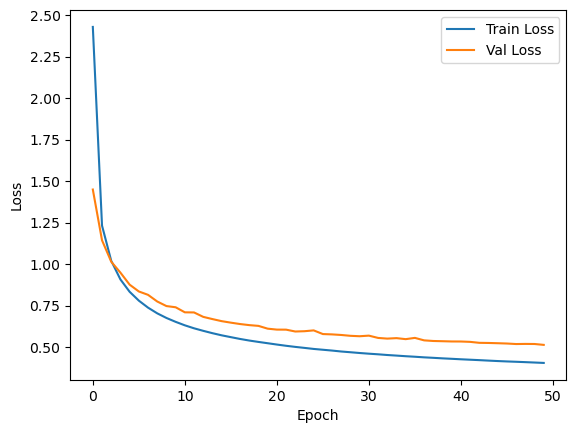

In [36]:
# Plot the training and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

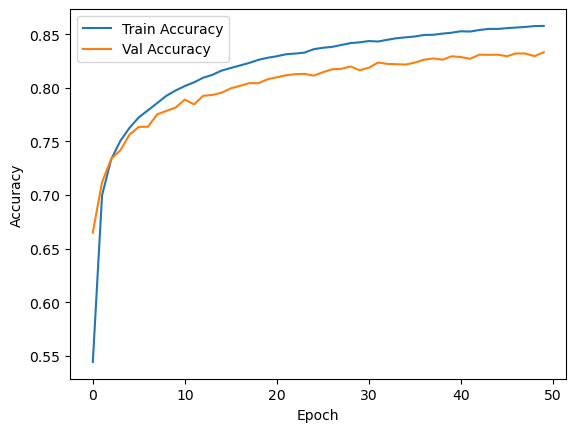

In [38]:
# Plot the training and validation accuracy in secondary y-axis
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Load the best model and test on the test set

In [35]:
best_model = pickle.load(open(working_dir + '/models/best_model.pkl', 'rb'))
total_acc = []
for inputs, targets in test_dataloader:
    targets = targets.flatten()
    probs = best_model.forward(inputs)
    y_pred = np.argmax(probs, axis=1)
    total_acc.append((y_pred == targets).mean())

# Print the test accuracy by percentage
print(f'The best model achieves a test accuracy: {np.mean(total_acc) * 100:.2f}%')

The best model achieves a test accuracy: 83.03%


## Visualize the Weight

In [48]:
import scipy
class PCA():
    def __init__(self):
        self.array = None
        self.w = None
    
    def fit(self, X):
        Sigma = np.cov(X, rowvar=True)
        ret = scipy.linalg.schur(Sigma, sort=lambda x: abs(x))
        self.w, self.array = ret[0], ret[1]
        self.w = np.diag(self.w)
    
    def transform(self, X, n):
        return np.dot(self.array[:, 1:min(len(self.w), n+1)].T, X)
    
    def fit_transform(self, X, n):
        self.fit(X)
        return self.transform(X, n)

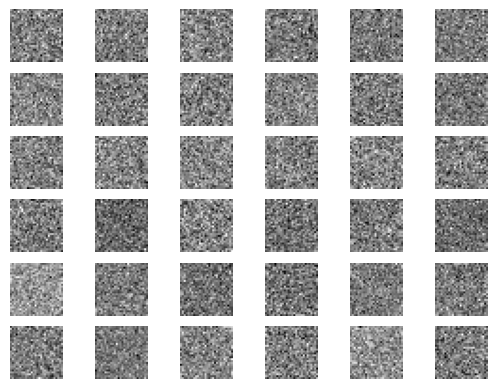

In [47]:
pca = PCA()
# net.layers[0].weight.transpose().shape
weight_fc1 = pca.fit_transform(best_model.layers[0].weights, 36).reshape(36, 28, 28)
for i in range(36):
    plt.subplot(6, 6, i+1)
    plt.imshow(weight_fc1[i])
    plt.axis('off')
    plt.gray()

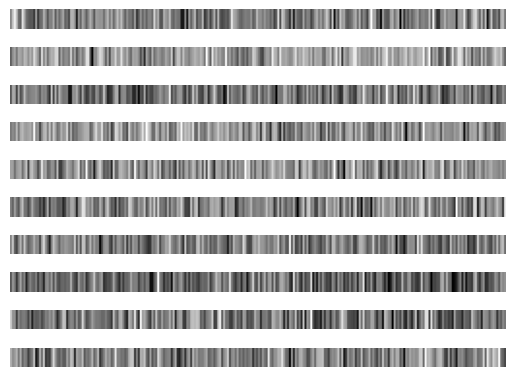

In [49]:
weight_fc2 = best_model.layers[2].weights.reshape(10, -1)
for i in range(10):
    plt.subplot(10, 1, i+1)
    plt.imshow(np.tile(weight_fc2[i], (10, 1)))
    plt.axis('off')
    plt.gray()